## Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import json
import math
import random
import pickle
import numpy as np
import pandas as pd
from tabulate import tabulate
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, matthews_corrcoef

import torch
import torch.nn as nn
from torch.optim import Adam, AdamW, SGD
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from transformers import get_linear_schedule_with_warmup
from transformers import BertTokenizer, Trainer, TrainingArguments,AutoTokenizer, BertForPreTraining
from transformers import DataCollatorWithPadding,AutoModelForSequenceClassification, AutoModel,AutoConfig
from transformers.modeling_outputs import TokenClassifierOutput


## Read Dataset

In [3]:
df = pickle.load(open('dataset/230130_SmallOberkategorie.pickle', 'rb'))

label_names = df['labels'].unique()
label_names

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21], dtype=int8)

Text(0, 0.5, 'Count')

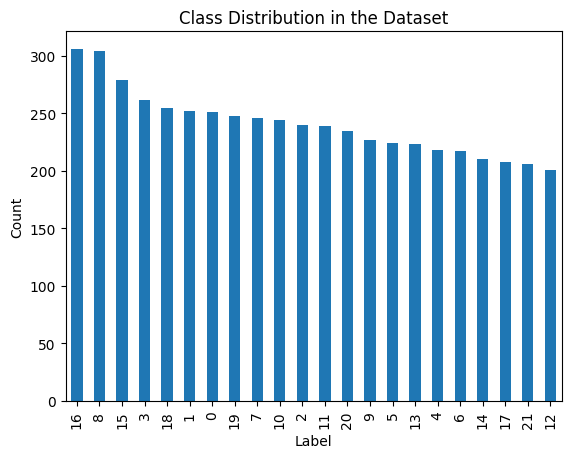

In [4]:
df['labels'].value_counts().plot(kind='bar')
plt.title("Class Distribution in the Dataset")
plt.xlabel("Label")
plt.ylabel("Count")

# Data Preprocessing
## Train Test Split

In [5]:
def split_df(X, y):    

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, random_state=42)

    fig, axes = plt.subplots(figsize=(12,4),nrows=1, ncols=2)

    ax1=axes[0]
    y_train.value_counts().plot(ax= ax1, kind='bar')
    ax1.set_title("Class Distribution in the Train Set")
    ax1.set_xlabel("Label")
    ax1.set_ylabel("Count")


    ax2=axes[1]
    y_val.value_counts().plot(ax=ax2, kind='bar')
    ax2.set_title("Class Distribution in the Test Set")
    ax2.set_xlabel("Label")
    ax2.set_ylabel("Count")
    plt.show()
    
    return X_train, X_val, y_train, y_val

## Tokenization

In [6]:
def tokenize(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)
    return tokenizer

# uncommment this function in case of mot propoerly encode the model
# def tokenize(model_name):
#     try:
#         tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=True)
#     except:
#         tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)
#     return tokenizer

## Encode datasets

In [7]:
def encode(docs, tokenizer):
    '''
    This function takes list of texts and returns input_ids and attention_mask of texts
    '''
    encoded_dict = tokenizer.batch_encode_plus(docs, add_special_tokens=True, max_length=128, padding='max_length',
                            return_attention_mask=True, truncation=True, return_tensors='pt')
    input_ids = encoded_dict['input_ids']
    attention_masks = encoded_dict['attention_mask']
    return input_ids, attention_masks

## Process datasets

In [8]:
def preprocess_dataset(model_name, X, y, batch_size):
    # initialize tokenizer
    tokenizer = tokenize(model_name)
    
    # encode dataset with the tokenizer
    train_input_ids, train_att_masks = encode(X['text'].values.tolist(), tokenizer)

    
    # convert the labels into tensor
    train_y = torch.LongTensor(y.values.tolist())

    
    # convert the encoded dataset into dataloaders
    train_dataset = TensorDataset(train_input_ids, train_att_masks, train_y)
    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
    
    return train_dataloader

# Transformer Models
## Model Creation

In [9]:
class CustomModel1(nn.Module):
    def __init__(self, checkpoint, num_labels, freeze_layers=True):
        super(CustomModel1, self).__init__()
        self.num_labels = num_labels
        
        # Load pre-trained model and freeze all layers except the classifier
        config = AutoConfig.from_pretrained(checkpoint, num_labels=num_labels)
        pretrain_model = BertForPreTraining.from_pretrained(checkpoint, config=config)
        self.model = pretrain_model.bert
        
        for param in self.model.parameters():
            param.requires_grad = not freeze_layers
            
        # Create a new classifier head
        self.classifier = nn.Linear(config.hidden_size, num_labels)
        
    def forward(self, input_ids=None, attention_mask=None, labels=None):
        # Feed input through the base model
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)

        # Extract the last hidden state and compute logits
        last_hidden_state = outputs.last_hidden_state[:, 0]
        logits = self.classifier(last_hidden_state)

        # Compute loss if labels are provided
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states, attentions=outputs.attentions)


In [10]:
class CustomModel2(nn.Module):
    def __init__(self, checkpoint, num_labels, freeze_layers=True): 
        super(CustomModel2, self).__init__() 
        self.num_labels = num_labels 

        # Load Model with given checkpoint and extract its body
        config = AutoConfig.from_pretrained(checkpoint, num_labels=num_labels, output_attentions=True, output_hidden_states=True)
        pretrain_model = BertForPreTraining.from_pretrained(checkpoint, config=config)
        self.model = pretrain_model.bert

        # Freeze all base model layers except the classification layer
        for name, param in self.model.named_parameters():
            if 'classifier' not in name:  # classifier layer should not be frozen
                param.requires_grad = not freeze_layers

        
        # Add custom layers
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.hidden_layer1 = nn.Linear(768, 512)
        self.hidden_layer2 = nn.Linear(512, 256)
        self.hidden_layer3 = nn.Linear(256, 768)
        self.classifier = nn.Linear(768, num_labels)
        
        
    def forward(self, input_ids=None, attention_mask=None, labels=None):
        # Extract outputs from the body
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)

        # Add custom layers
        sequence_output = self.dropout(outputs[0])  # outputs[0]=last hidden state
        hidden_output1 = self.activation(self.hidden_layer1(sequence_output))
        hidden_output2 = self.activation(self.hidden_layer2(hidden_output1))
        hidden_output3 = self.hidden_layer3(hidden_output2)
        final_output = self.dropout(hidden_output3)
        logits = self.classifier(final_output[:,0,:].view(-1, final_output.size(-1)))  # calculate losses

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states, attentions=outputs.attentions)


In [11]:
# class CustomModel(nn.Module):
#     def __init__(self, checkpoint, num_labels): 
#         super(CustomModel,self).__init__() 
#         self.num_labels = num_labels 

#         #Load Model with given checkpoint and extract its body
#         # Load Model with given checkpoint and extract its body
#         config = AutoConfig.from_pretrained(checkpoint, output_hidden_states=True, output_attentions=True)
#         self.model = AutoModel.from_pretrained(checkpoint, config=config)
#         self.dropout = nn.Dropout(0.1) 
#         self.classifier = nn.Linear(768,num_labels) # set sequence length



#     def forward(self, input_ids=None, attention_mask=None,labels=None):
#         #Extract outputs from the body
#         outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)

#         #Add custom layers
#         sequence_output = self.dropout(outputs[0]) #outputs[0]=last hidden state

#         logits = self.classifier(sequence_output[:,0,:].view(-1,768)) # calculate losses

#         loss = None
#         if labels is not None:
#           # set class weights here  
#     #           device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     #           class_weights = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]).to(device) # set weights here
#           loss_fct = nn.CrossEntropyLoss()
#           loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

#         return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states,attentions=outputs.attentions)

## Model Trainer
<span style='color:red'>P1<span>

In [12]:
def trainer(model, batch_size, optimizer, epochs, train_dataloader, valid_dataloader, val_steps):

    steps = 0
    train_acc_per_epoch = []
    train_loss_per_epoch = []
    val_acc_per_epoch = []
    val_loss_per_epoch = []
    
    # Set the seed for reproducibility
    seed_val = 42
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                 num_warmup_steps=0,
                num_training_steps=len(train_dataloader)*epochs )

    
    train_loss = 0
    train_total_correct = 0
    train_total_examples = 0
    
    for epoch_num in range(epochs):
        print('Epoch: ', epoch_num + 1)
        '''
        Training
        '''
        model.train()

        for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            loss = output.loss
            train_loss += loss.item()

            model.zero_grad()
            loss.backward()
            del loss

            clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            
            # update accuracy
            _, predicted = torch.max(output.logits, dim=1)
            train_total_correct += (predicted == labels).sum().item()
            train_total_examples += labels.size(0)            
            steps += 1
            
            '''
            Validation
            '''

            if steps >= val_steps:
                
                model.eval()
                val_total_correct = 0
                val_total_examples = 0
                valid_loss = 0
                valid_pred = []
                valid_label = []
                with torch.no_grad():
                    for step_num_e, batch_data in enumerate(tqdm(valid_dataloader,desc='Validation')):
                        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
                        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

                        loss = output.loss
                        valid_loss += loss.item()

                        valid_label.append(labels.cpu().detach().numpy())
                        valid_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))

                        # update accuracy
                        _, predicted = torch.max(output.logits, dim=1)
                        val_total_correct += (predicted == labels).sum().item()
                        val_total_examples += labels.size(0)
                
                val_acc_per_epoch.append(val_total_correct / val_total_examples)
                val_loss_per_epoch.append(valid_loss / steps)
                
                valid_label = np.concatenate(valid_label)
                valid_pred = np.concatenate(valid_pred)
                
                print("{0}/{1} val accuracy: {2} ".format(steps, math.ceil(len(X_val) / batch_size), val_total_correct / val_total_examples))
                print("{0}/{1} val loss: {2} ".format(steps, math.ceil(len(X_val) / batch_size), valid_loss / steps))
                
                
                train_acc_per_epoch.append(train_total_correct / train_total_examples)
                train_loss_per_epoch.append(train_loss / steps)  

                print("{0}/{1} train accuracy: {2} ".format(steps, math.ceil(len(X_train) / batch_size), train_total_correct / train_total_examples))
                print("{0}/{1} train loss: {2} ".format(steps, math.ceil(len(X_train) / batch_size), train_loss / steps + 1))
                
                steps = 0
                train_loss = 0
                train_total_correct = 0
                train_total_examples = 0
    return model, train_acc_per_epoch, train_loss_per_epoch, val_acc_per_epoch, val_loss_per_epoch, valid_label, valid_pred

## Evaluation and Plotting

In [13]:
def plot_acc(epochs, train_acc_per_epoch, val_acc_per_epoch, model_name="Initial"):
    epochs_list = range(1, len(train_acc_per_epoch) +1 )
    fig, ax = plt.subplots()
    ax.plot(epochs_list,train_acc_per_epoch,label ='training accuracy')
    ax.plot(epochs_list,val_acc_per_epoch,label ='validation accuracy')
    ax.set_title('Training and Validation Accuracy of {} model'.format(model_name))
    ax.set_xlabel('Steps')
    ax.set_ylabel('Accuracy')
    ax.legend()
    img_url = 'figures/accuracy-train-' + model_name + '.png' 
    plt.savefig(img_url)
    plt.show()
    
def plot_loss(epochs, train_loss_per_epoch, val_loss_per_epoch, model_name="Initial"):
    epochs_list = range(1, len(train_loss_per_epoch) +1 )
    fig, ax = plt.subplots()
    ax.plot(epochs_list,train_loss_per_epoch,label ='train loss')
    ax.plot(epochs_list, val_loss_per_epoch, label = 'validation loss' )
    ax.set_title('Training and Validation Loss of {} model'.format(model_name))
    ax.set_xlabel('Steps')
    ax.set_ylabel('Loss')
    ax.legend()
    img_url = 'figures/loss-train-' + model_name + '.png' 
    plt.savefig(img_url)
    plt.show()

In [14]:
def calculate_classification_reprot(label_names, val_label, valid_pred, model_name="Initial"):
    label_names_str = [str(x) for x in label_names]
    print('classifiation report of {} model'.format(model_name))
    print(classification_report(valid_pred, val_label, target_names=label_names_str))

In [15]:
def plot_confusion_matrix(y_preds, y_true, label_names, training=False, model_name="Initial"):
    label_names_str = [str(x) for x in label_names]
    cm = confusion_matrix(y_true, y_preds, normalize=None)
    
    index= 0
    data = []
    for row in cm:
        label = label_names[index]
        total_correct = row[index]
        total_count = row.sum()
        data.append([label, total_correct, total_count])
        index += 1
    
    # Create the pandas DataFrame
    df = pd.DataFrame(data, columns = ['Label', 'Correct_preds', 'Total_preds'])
    print(df)

In [16]:
def get_evaluation_results(y_test_set, predictions):
    #store results of model
    acc = accuracy_score(y_test_set, predictions)
    precision = precision_score(y_test_set, predictions,average='macro')
    recall = recall_score(y_test_set, predictions,average='macro')
    f1 = f1_score(y_test_set, predictions,average='macro')
    mcc = matthews_corrcoef(y_test_set, predictions)
    
    results = [round(acc, 4), round(precision, 4), round(recall, 4), round(f1, 4), round(mcc, 4)]
    return results

## Training

In [17]:
def training(models, configs, dataset):
    custom_head = configs['custom_head']
    freeze_layers = configs['freeze_layers']
    optimizers = configs['optimizers']
    epochs = configs['epochs']
    batch_sizes = configs['batch_sizes']
    learning_rates = configs['learning_rates']
    val_steps = configs['val_steps']
    
    custom_head_label = 'custom' if custom_head else 'base'
    model_function = CustomModel2 if custom_head else CustomModel1
    
    X_train, y_train, X_val, y_val = dataset.values() 
    
    # dic form store results of all models
    collect_train_results_of_all_model= {
        'Metrics':['accuracy','precision','recall','f1-score', 'MCC']
    }
    
    if os.path.exists(trained_models_file):
        with open(trained_models_file, 'r') as f:
            trained_models = [line.strip() for line in f]
            f.close()
    else:
        trained_models = []
            
    
    if os.path.exists(best_params_dict_path):
        with open(best_params_dict_path, 'r') as params_file:
            best_prams = json.load(params_file)
    else:
        best_prams = {}
    
    
    for model_name in models:    
        model_str = str(model_name).replace('/', '-')
        model_identifier = custom_head_label + '-' + model_str
        if best_prams.get(model_str) == None:
            best_prams[model_identifier] = dict.fromkeys(['best_acc', 'optimizer', 'epochs',
                            'batch_size', 'learning_rate'], 0.0)
            
        for batch_size in batch_sizes:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            train_dataloader = preprocess_dataset(model_name, X_train, y_train, batch_size)
            valid_dataloader = preprocess_dataset(model_name, X_val, y_val, batch_size)
            
            for optimizer_name in optimizers:
                for learning_rate in learning_rates:
                    for num_epochs in epochs:
                        
                        optimizer_str = str(optimizer_name).split('.')[-1].split("'")[0]
                        epoch_str = 'epoch' + str(num_epochs)
                        lr_str = 'lr' + str(learning_rate)
                        batch_size_str = 'batchsize' + str(batch_size)
                        model_variant = f'{custom_head_label}-{model_str}-{optimizer_str}-{epoch_str}-{lr_str}-{batch_size_str}-freeze-layer:{str(freeze_layers)}'
                        
                        model_url = 'models/' + model_identifier + '.pth'
                        
                        if model_variant in trained_models:
                            continue
                            
                        print("===========================================")
                        print(f"Hyperparameters: \n {optimizer_str, lr_str, batch_size_str, epoch_str} \n")
                        print("Start Training of {}".format(model_variant))
                        print("===========================================")
                        
                        
                        model = model_function(checkpoint=model_name, num_labels=len(label_names), freeze_layers=freeze_layers).to(device)
                        optimizer = optimizer_name(model.parameters(), lr=learning_rate)
                        if not freeze_layers:
                            model.load_state_dict(torch.load(model_url))
                        model, train_acc_per_epoch, train_loss_per_epoch, val_acc_per_epoch, val_loss_per_epoch, valid_label, valid_pred = trainer(model, batch_size, optimizer, num_epochs, train_dataloader, valid_dataloader, val_steps)

                        val_total_correct = (valid_label == valid_pred).sum().item()
                        val_acc =  val_total_correct/len(valid_label)
                        print(val_acc)
                        
                        plot_acc(num_epochs, train_acc_per_epoch, val_acc_per_epoch, model_variant)
                        plot_loss(num_epochs, train_loss_per_epoch, val_loss_per_epoch, model_variant)
                        plot_confusion_matrix(valid_pred, valid_label, label_names, True, model_variant)
                        collect_train_results_of_all_model[model_variant] = get_evaluation_results(valid_label, valid_pred)
                        print("\n\n")
                        
                        with open(trained_models_file, 'a') as f:
                            f.write(f'{model_variant} \n')
                            
                        if val_acc > best_prams[model_identifier]['best_acc']:
                            best_prams[model_identifier]['best_acc'] = val_acc
                            best_prams[model_identifier]['optimizer'] = optimizer_str
                            best_prams[model_identifier]['epochs'] = num_epochs
                            best_prams[model_identifier]['batch_size'] = batch_size
                            best_prams[model_identifier]['learning_rate'] = learning_rate
                            best_prams[model_identifier]['custom_head'] = custom_head
                            best_prams[model_identifier]['freeze_layers'] = freeze_layers

                            with open(best_params_dict_path, "w") as fp:
                                json.dump(best_prams, fp)  # encode dict into JSON
                            torch.save(model.state_dict(), model_url)
        
    metrics_data_frame = pd.DataFrame.from_dict(collect_train_results_of_all_model, orient='index')
    print(tabulate(metrics_data_frame, tablefmt="fancy_grid")) # convert results in to table

## Configurations and Settings
<span style='color:red'>P2<span>

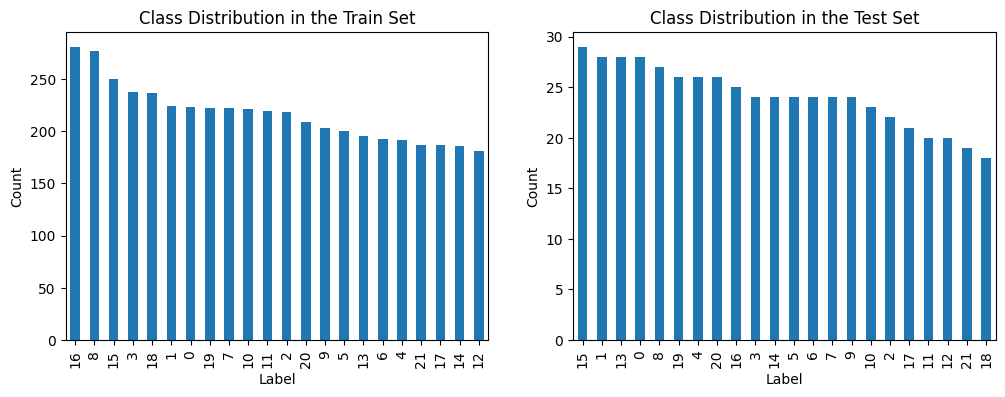

Hyperparameters: 
 ('Adam', 'lr2e-06', 'batchsize16', 'epoch2') 

Start Training of base-Bert-base-german-cased-Adam-epoch2-lr2e-06-batchsize16-freeze-layer:True
Epoch:  1


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.052830188679245285 
100/34 val loss: 1.0731540632247925 
100/298 train accuracy: 0.05 
100/298 train loss: 4.165275661945342 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.05660377358490566 
100/34 val loss: 1.071478579044342 
100/298 train accuracy: 0.061875 
100/298 train loss: 4.149840712547302 
Epoch:  2


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.05849056603773585 
100/34 val loss: 1.0639674401283263 
100/298 train accuracy: 0.07576706324358172 
100/298 train loss: 4.138957660198212 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.06037735849056604 
100/34 val loss: 1.0664741611480713 
100/298 train accuracy: 0.07 
100/298 train loss: 4.133060328960418 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.06037735849056604 
100/34 val loss: 1.0609601354598999 
100/298 train accuracy: 0.076875 
100/298 train loss: 4.120380008220673 
0.06037735849056604


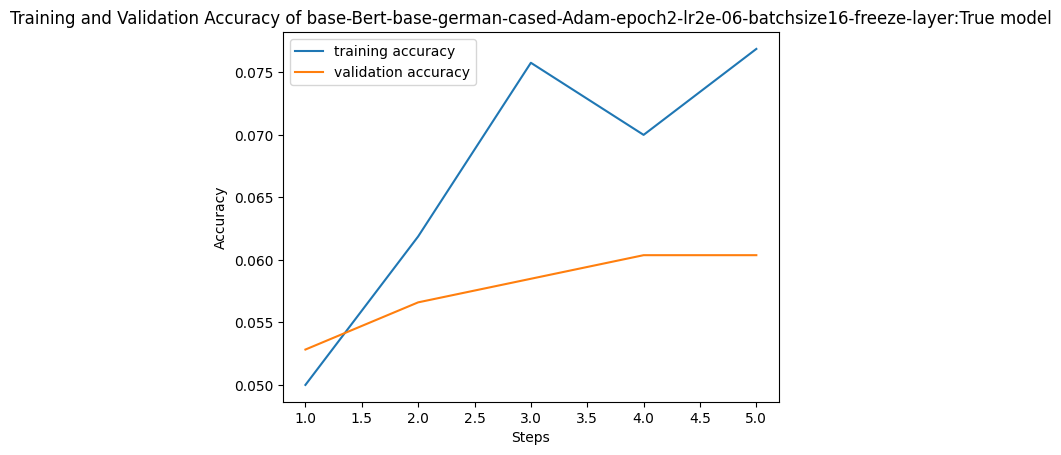

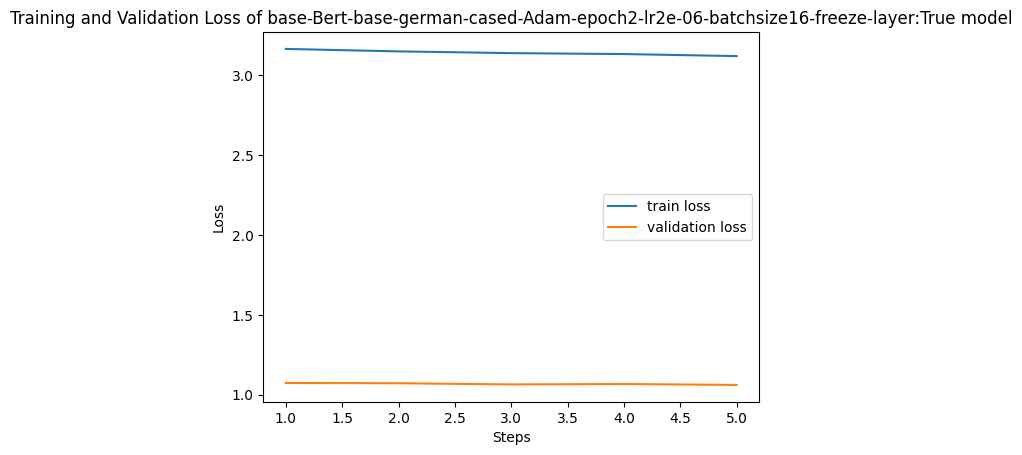

    Label  Correct_preds  Total_preds
0       0              0           28
1       1              3           28
2       2             19           22
3       3              0           24
4       4              0           26
5       5              1           24
6       6              2           24
7       7              0           24
8       8              4           27
9       9              0           24
10     10              0           23
11     11              0           20
12     12              0           20
13     13              0           28
14     14              0           24
15     15              1           29
16     16              0           25
17     17              0           21
18     18              0           18
19     19              2           26
20     20              0           26
21     21              0           19



Hyperparameters: 
 ('Adam', 'lr2e-06', 'batchsize16', 'epoch2') 

Start Training of base-Dbmdz-bert-base-german-uncased-Ada

Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.013207547169811321 
100/34 val loss: 1.0950020694732665 
100/298 train accuracy: 0.040625 
100/298 train loss: 4.197499339580536 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.016981132075471698 
100/34 val loss: 1.088791437149048 
100/298 train accuracy: 0.02625 
100/298 train loss: 4.216158254146576 
Epoch:  2


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.016981132075471698 
100/34 val loss: 1.0888058137893677 
100/298 train accuracy: 0.028177833437695678 
100/298 train loss: 4.2045164799690244 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.016981132075471698 
100/34 val loss: 1.0865990781784058 
100/298 train accuracy: 0.023125 
100/298 train loss: 4.190981948375702 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.016981132075471698 
100/34 val loss: 1.0826488995552064 
100/298 train accuracy: 0.030625 
100/298 train loss: 4.187784724235534 
0.016981132075471698


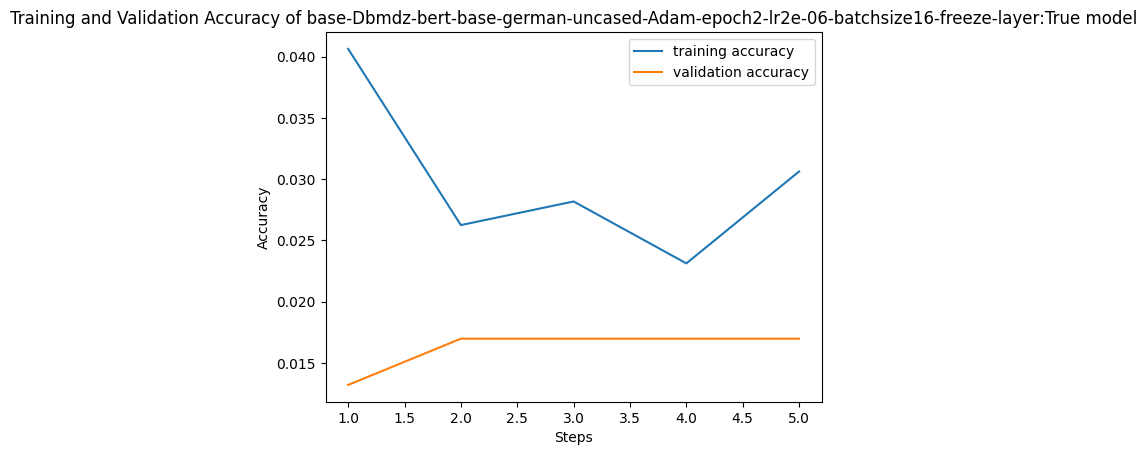

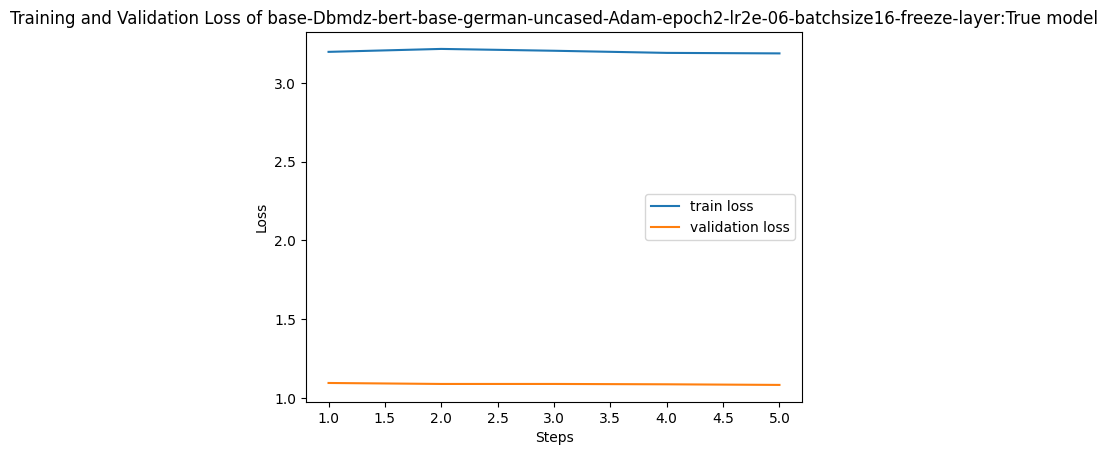

    Label  Correct_preds  Total_preds
0       0              0           28
1       1              0           28
2       2              0           22
3       3              2           24
4       4              0           26
5       5              0           24
6       6              0           24
7       7              0           24
8       8              0           27
9       9              0           24
10     10              3           23
11     11              0           20
12     12              0           20
13     13              0           28
14     14              2           24
15     15              2           29
16     16              0           25
17     17              0           21
18     18              0           18
19     19              0           26
20     20              0           26
21     21              0           19



Hyperparameters: 
 ('Adam', 'lr2e-06', 'batchsize16', 'epoch2') 

Start Training of base-Deepset-gbert-base-Adam-epoch2-lr2

Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.0660377358490566 
100/34 val loss: 1.0723489069938659 
100/298 train accuracy: 0.0525 
100/298 train loss: 4.168397448062897 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.08867924528301886 
100/34 val loss: 1.0692760038375855 
100/298 train accuracy: 0.061875 
100/298 train loss: 4.146935205459595 
Epoch:  2


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.09433962264150944 
100/34 val loss: 1.0660071349143982 
100/298 train accuracy: 0.06449592986850344 
100/298 train loss: 4.152482216358185 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.09433962264150944 
100/34 val loss: 1.0693969631195068 
100/298 train accuracy: 0.075625 
100/298 train loss: 4.132322340011596 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.09433962264150944 
100/34 val loss: 1.0654061126708985 
100/298 train accuracy: 0.07125 
100/298 train loss: 4.123378038406372 
0.09433962264150944


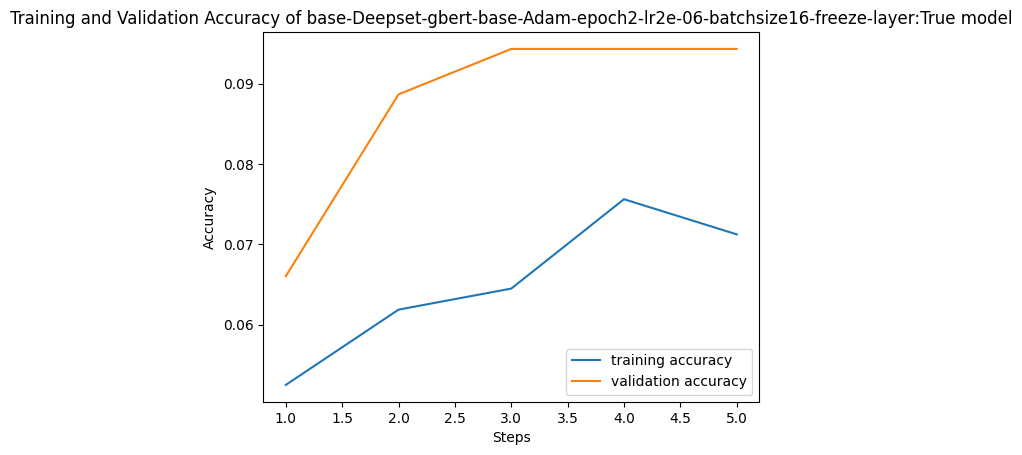

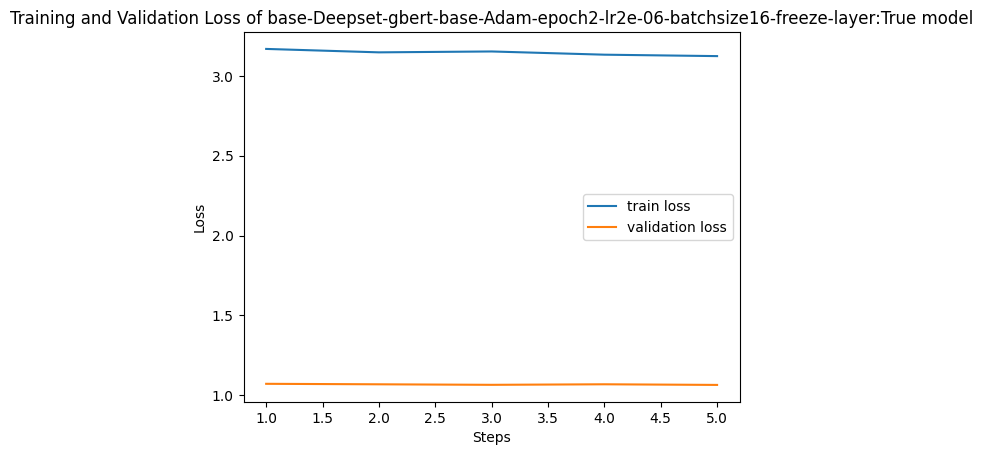

    Label  Correct_preds  Total_preds
0       0              0           28
1       1              0           28
2       2              0           22
3       3              3           24
4       4             16           26
5       5             19           24
6       6              1           24
7       7              0           24
8       8              0           27
9       9              0           24
10     10              0           23
11     11              3           20
12     12              0           20
13     13              2           28
14     14              0           24
15     15              0           29
16     16              0           25
17     17              0           21
18     18              3           18
19     19              0           26
20     20              3           26
21     21              0           19



Hyperparameters: 
 ('Adam', 'lr2e-06', 'batchsize16', 'epoch2') 

Start Training of base-Xlm-roberta-base-Adam-epoch2-lr2e-

Some weights of the model checkpoint at Xlm-roberta-base were not used when initializing BertForPreTraining: ['roberta.encoder.layer.4.intermediate.dense.weight', 'roberta.encoder.layer.11.output.dense.bias', 'roberta.encoder.layer.5.attention.self.key.weight', 'roberta.encoder.layer.7.attention.self.key.bias', 'roberta.encoder.layer.10.attention.self.query.weight', 'roberta.encoder.layer.3.attention.output.LayerNorm.weight', 'roberta.encoder.layer.10.attention.self.key.weight', 'roberta.encoder.layer.3.output.LayerNorm.bias', 'roberta.encoder.layer.7.attention.output.LayerNorm.weight', 'roberta.encoder.layer.9.attention.self.query.bias', 'roberta.encoder.layer.11.attention.self.value.weight', 'roberta.encoder.layer.6.output.dense.weight', 'roberta.encoder.layer.7.output.dense.weight', 'roberta.encoder.layer.8.attention.self.key.bias', 'roberta.encoder.layer.9.attention.self.value.weight', 'lm_head.layer_norm.bias', 'roberta.encoder.layer.11.output.LayerNorm.weight', 'roberta.encoder.l

Some weights of BertForPreTraining were not initialized from the model checkpoint at Xlm-roberta-base and are newly initialized: ['encoder.layer.2.output.LayerNorm.bias', 'encoder.layer.1.output.dense.bias', 'encoder.layer.5.output.LayerNorm.bias', 'encoder.layer.9.attention.self.key.bias', 'encoder.layer.10.attention.self.key.bias', 'encoder.layer.10.output.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'cls.predictions.bias', 'encoder.layer.5.attention.output.dense.bias', 'encoder.layer.2.intermediate.dense.bias', 'encoder.layer.7.attention.output.LayerNorm.weight', 'encoder.layer.2.attention.self.key.bias', 'encoder.layer.0.output.dense.bias', 'encoder.layer.10.attention.output.LayerNorm.weight', 'encoder.layer.6.attention.output.LayerNorm.weight', 'encoder.layer.7.attention.self.key.weight', 'encoder.layer.1.attention.self.key.weight', 'encoder.layer.6.output.LayerNorm.weight', 'encoder.layer.1.attention.output.LayerNorm.weight', 'encoder.layer.3.attention.self.key.bias'

Epoch:  1


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.04716981132075472 
100/34 val loss: 1.0957585644721985 
100/298 train accuracy: 0.038125 
100/298 train loss: 4.227284853458404 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.04716981132075472 
100/34 val loss: 1.089583923816681 
100/298 train accuracy: 0.044375 
100/298 train loss: 4.1881912374496455 
Epoch:  2


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.05660377358490566 
100/34 val loss: 1.086213161945343 
100/298 train accuracy: 0.049467752035065746 
100/298 train loss: 4.170611703395844 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.06415094339622641 
100/34 val loss: 1.0819702124595643 
100/298 train accuracy: 0.0575 
100/298 train loss: 4.1678278493881225 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.06415094339622641 
100/34 val loss: 1.0810102438926696 
100/298 train accuracy: 0.06 
100/298 train loss: 4.147737321853638 
0.06415094339622641


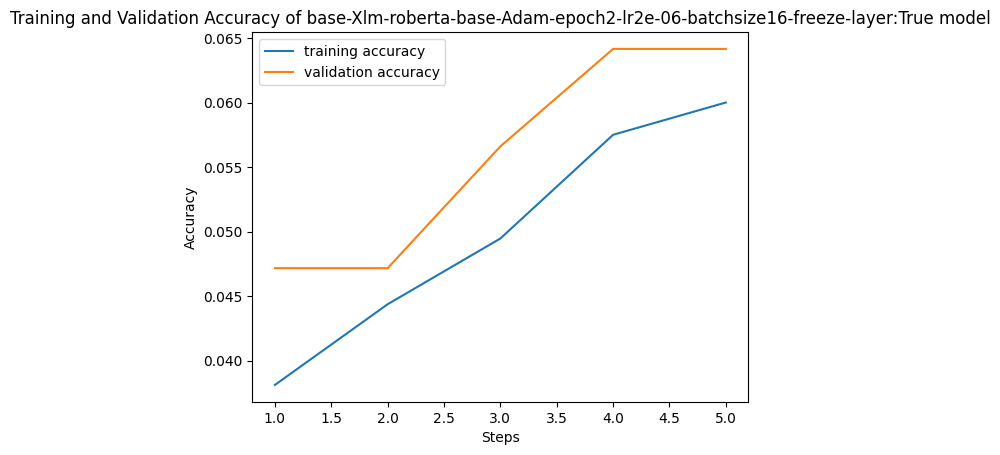

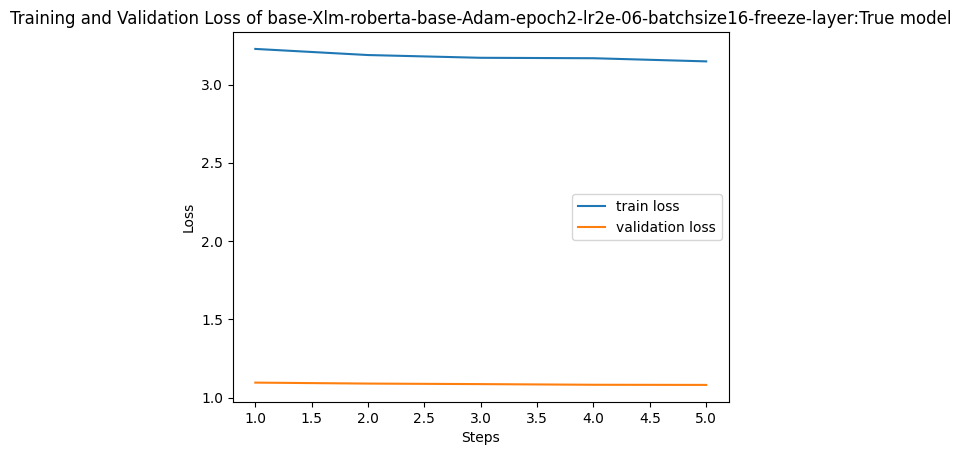

    Label  Correct_preds  Total_preds
0       0              0           28
1       1              0           28
2       2             16           22
3       3              0           24
4       4              0           26
5       5              0           24
6       6              0           24
7       7              0           24
8       8              0           27
9       9              0           24
10     10              0           23
11     11              0           20
12     12              0           20
13     13              0           28
14     14              0           24
15     15              0           29
16     16              0           25
17     17              0           21
18     18              0           18
19     19              0           26
20     20             18           26
21     21              0           19



Hyperparameters: 
 ('Adam', 'lr2e-06', 'batchsize16', 'epoch2') 

Start Training of base-Uklfr-gottbert-base-Adam-epoch2-lr

Some weights of the model checkpoint at Uklfr/gottbert-base were not used when initializing BertForPreTraining: ['roberta.encoder.layer.4.intermediate.dense.weight', 'roberta.encoder.layer.11.output.dense.bias', 'roberta.encoder.layer.5.attention.self.key.weight', 'roberta.encoder.layer.7.attention.self.key.bias', 'roberta.encoder.layer.10.attention.self.query.weight', 'roberta.encoder.layer.3.attention.output.LayerNorm.weight', 'roberta.encoder.layer.10.attention.self.key.weight', 'roberta.encoder.layer.3.output.LayerNorm.bias', 'roberta.encoder.layer.7.attention.output.LayerNorm.weight', 'roberta.encoder.layer.9.attention.self.query.bias', 'roberta.encoder.layer.11.attention.self.value.weight', 'roberta.encoder.layer.6.output.dense.weight', 'roberta.encoder.layer.7.output.dense.weight', 'roberta.encoder.layer.8.attention.self.key.bias', 'roberta.encoder.layer.9.attention.self.value.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'roberta.encoder.layer.11.output.LayerNorm.

Some weights of BertForPreTraining were not initialized from the model checkpoint at Uklfr/gottbert-base and are newly initialized: ['encoder.layer.2.output.LayerNorm.bias', 'encoder.layer.1.output.dense.bias', 'encoder.layer.5.output.LayerNorm.bias', 'encoder.layer.9.attention.self.key.bias', 'encoder.layer.10.attention.self.key.bias', 'encoder.layer.10.output.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'cls.predictions.bias', 'encoder.layer.5.attention.output.dense.bias', 'encoder.layer.2.intermediate.dense.bias', 'encoder.layer.7.attention.output.LayerNorm.weight', 'encoder.layer.2.attention.self.key.bias', 'encoder.layer.0.output.dense.bias', 'encoder.layer.10.attention.output.LayerNorm.weight', 'encoder.layer.6.attention.output.LayerNorm.weight', 'encoder.layer.7.attention.self.key.weight', 'encoder.layer.1.attention.self.key.weight', 'encoder.layer.6.output.LayerNorm.weight', 'encoder.layer.1.attention.output.LayerNorm.weight', 'encoder.layer.3.attention.self.key.bi

Epoch:  1


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.035849056603773584 
100/34 val loss: 1.1339090442657471 
100/298 train accuracy: 0.03375 
100/298 train loss: 4.293868577480316 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.035849056603773584 
100/34 val loss: 1.1268189978599548 
100/298 train accuracy: 0.039375 
100/298 train loss: 4.295824127197266 
Epoch:  2


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.035849056603773584 
100/34 val loss: 1.116953432559967 
100/298 train accuracy: 0.045084533500313086 
100/298 train loss: 4.261136555671692 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.035849056603773584 
100/34 val loss: 1.1076240515708924 
100/298 train accuracy: 0.03625 
100/298 train loss: 4.24868152141571 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.035849056603773584 
100/34 val loss: 1.1089671421051026 
100/298 train accuracy: 0.04875 
100/298 train loss: 4.232596497535706 
0.035849056603773584


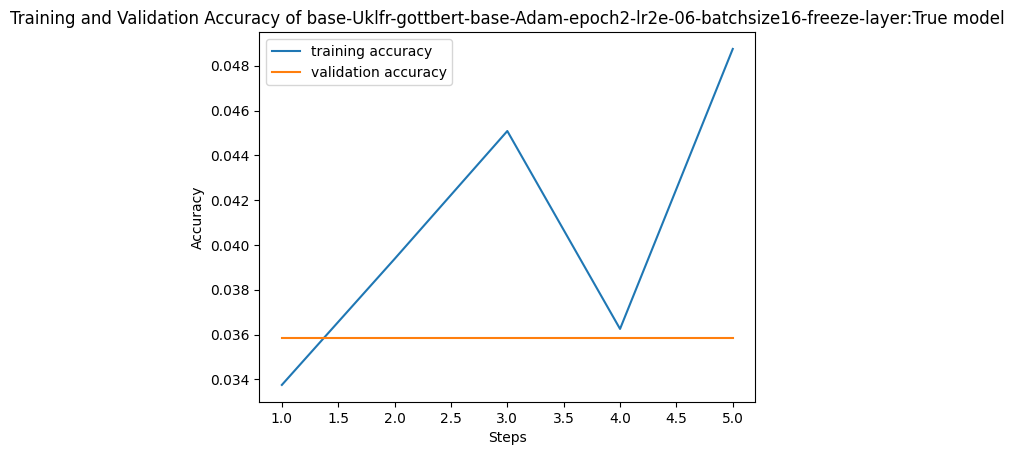

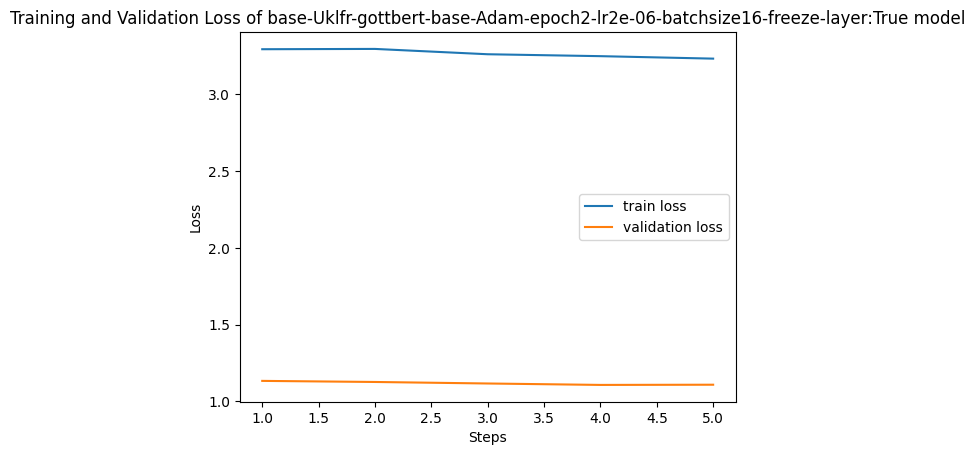

    Label  Correct_preds  Total_preds
0       0              0           28
1       1              0           28
2       2              0           22
3       3              0           24
4       4              0           26
5       5              0           24
6       6              0           24
7       7              0           24
8       8              0           27
9       9              0           24
10     10              0           23
11     11              0           20
12     12              0           20
13     13              0           28
14     14              0           24
15     15              0           29
16     16              0           25
17     17              0           21
18     18              0           18
19     19              0           26
20     20              0           26
21     21             19           19



╒═══════════════════════════════════════════════════════════════════════════════════════╤══════════╤═══════════╤════════╤══

Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.035849056603773584 
100/34 val loss: 1.0509035539627076 
100/298 train accuracy: 0.0425 
100/298 train loss: 4.092221019268036 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.035849056603773584 
100/34 val loss: 1.0496511363983154 
100/298 train accuracy: 0.040625 
100/298 train loss: 4.089113051891327 
Epoch:  2


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.04150943396226415 
100/34 val loss: 1.0484164333343506 
100/298 train accuracy: 0.035691922354414526 
100/298 train loss: 4.0842129898071295 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.07358490566037736 
100/34 val loss: 1.0476111149787903 
100/298 train accuracy: 0.055625 
100/298 train loss: 4.080752639770507 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.09811320754716982 
100/34 val loss: 1.0470843076705934 
100/298 train accuracy: 0.08 
100/298 train loss: 4.07991085767746 
0.09811320754716982


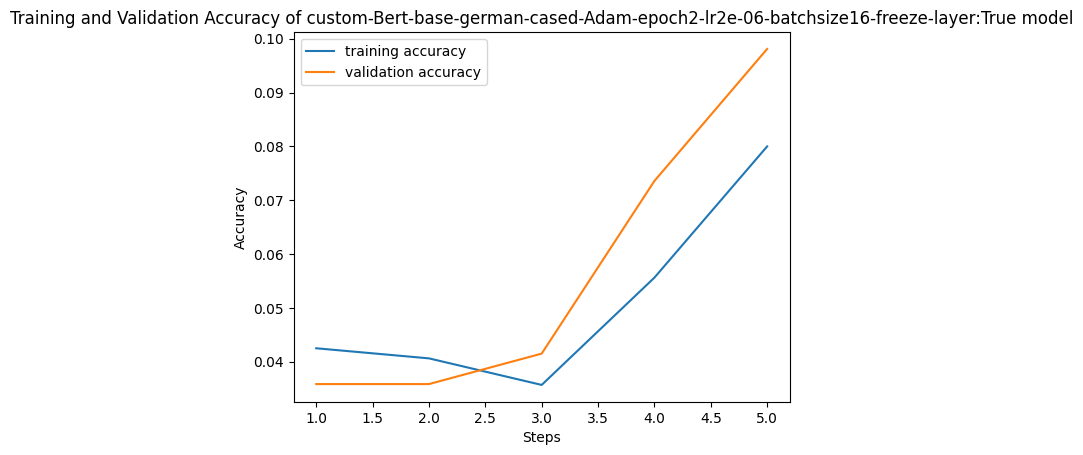

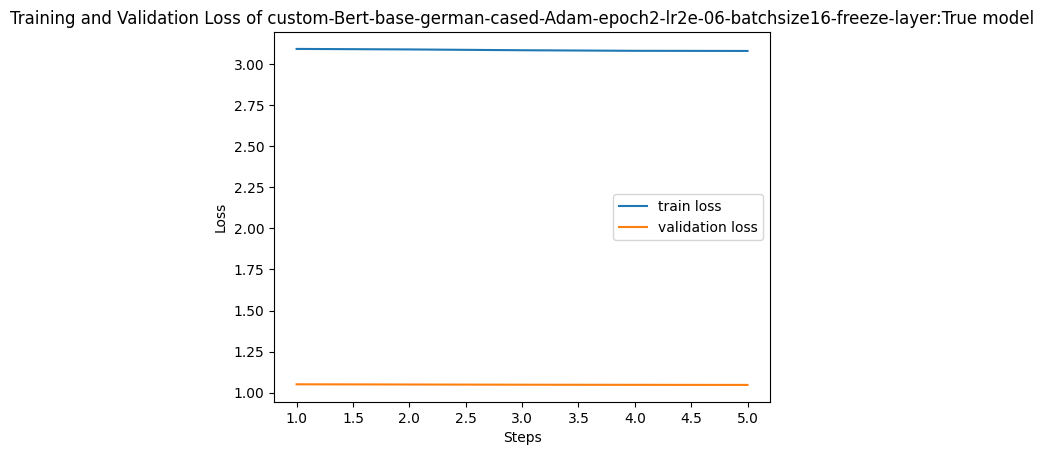

    Label  Correct_preds  Total_preds
0       0              0           28
1       1             14           28
2       2             17           22
3       3              0           24
4       4              0           26
5       5              0           24
6       6              2           24
7       7              0           24
8       8              0           27
9       9             15           24
10     10              0           23
11     11              0           20
12     12              0           20
13     13              0           28
14     14              0           24
15     15              2           29
16     16              2           25
17     17              0           21
18     18              0           18
19     19              0           26
20     20              0           26
21     21              0           19



Hyperparameters: 
 ('Adam', 'lr2e-06', 'batchsize16', 'epoch2') 

Start Training of custom-Dbmdz-bert-base-german-uncased-A

Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.03773584905660377 
100/34 val loss: 1.0498195672035218 
100/298 train accuracy: 0.049375 
100/298 train loss: 4.0882917857170105 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.04905660377358491 
100/34 val loss: 1.0479956102371215 
100/298 train accuracy: 0.048125 
100/298 train loss: 4.083966450691223 
Epoch:  2


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.05660377358490566 
100/34 val loss: 1.046576943397522 
100/298 train accuracy: 0.059486537257357544 
100/298 train loss: 4.082019791603088 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.0660377358490566 
100/34 val loss: 1.0463310742378236 
100/298 train accuracy: 0.065625 
100/298 train loss: 4.0752965259552 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.06981132075471698 
100/34 val loss: 1.0450713849067688 
100/298 train accuracy: 0.0725 
100/298 train loss: 4.074411909580231 
0.06981132075471698


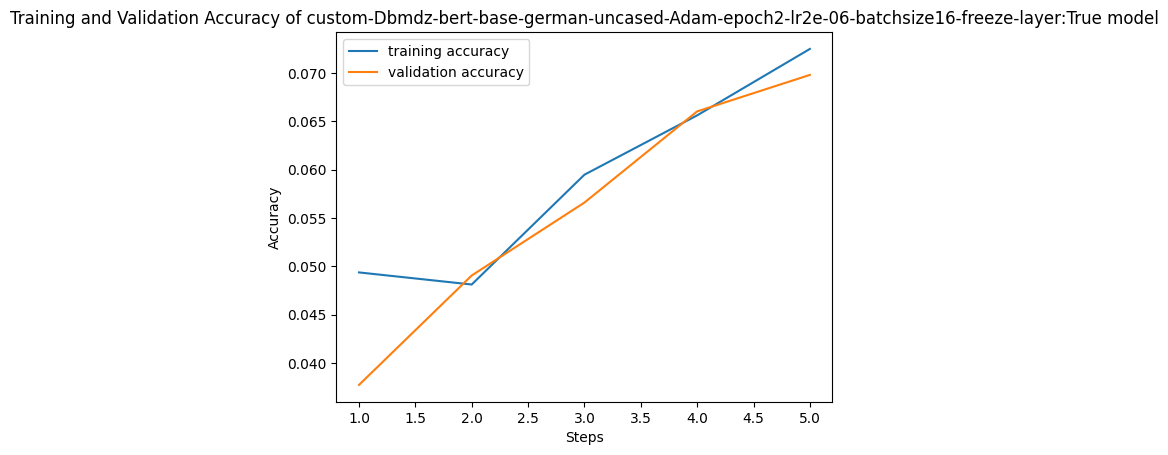

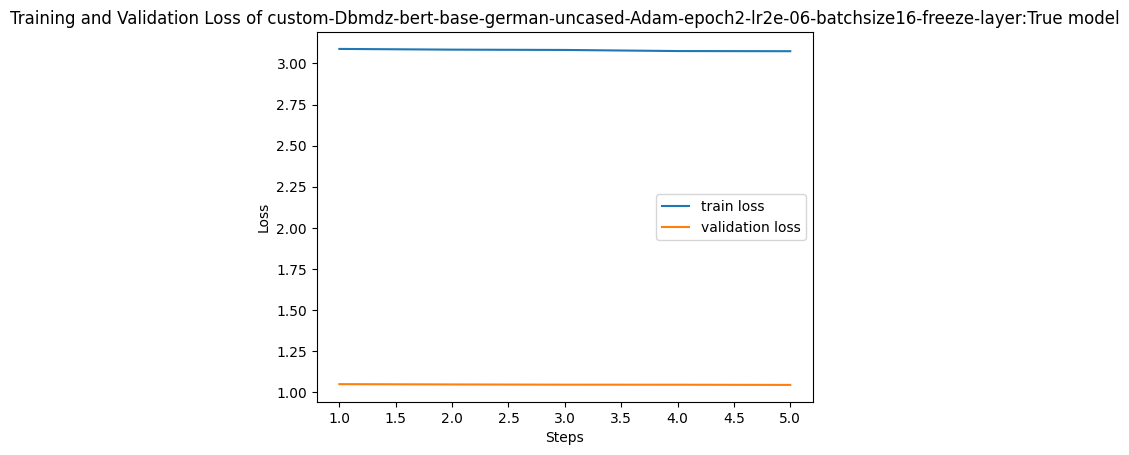

    Label  Correct_preds  Total_preds
0       0              0           28
1       1              0           28
2       2              0           22
3       3             12           24
4       4              0           26
5       5              0           24
6       6              0           24
7       7              0           24
8       8             13           27
9       9              0           24
10     10              6           23
11     11              0           20
12     12              0           20
13     13              0           28
14     14              0           24
15     15              0           29
16     16              0           25
17     17              0           21
18     18              4           18
19     19              2           26
20     20              0           26
21     21              0           19



Hyperparameters: 
 ('Adam', 'lr2e-06', 'batchsize16', 'epoch2') 

Start Training of custom-Deepset-gbert-base-Adam-epoch2-l

Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.04339622641509434 
100/34 val loss: 1.0499254560470581 
100/298 train accuracy: 0.039375 
100/298 train loss: 4.087588429450989 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.04905660377358491 
100/34 val loss: 1.0481115436553956 
100/298 train accuracy: 0.041875 
100/298 train loss: 4.0847718715667725 
Epoch:  2


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.05471698113207547 
100/34 val loss: 1.0454883122444152 
100/298 train accuracy: 0.046336881653099564 
100/298 train loss: 4.07924576997757 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.06792452830188679 
100/34 val loss: 1.0446386814117432 
100/298 train accuracy: 0.0575 
100/298 train loss: 4.072350254058838 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.07547169811320754 
100/34 val loss: 1.0430502033233642 
100/298 train accuracy: 0.07875 
100/298 train loss: 4.069398155212403 
0.07547169811320754


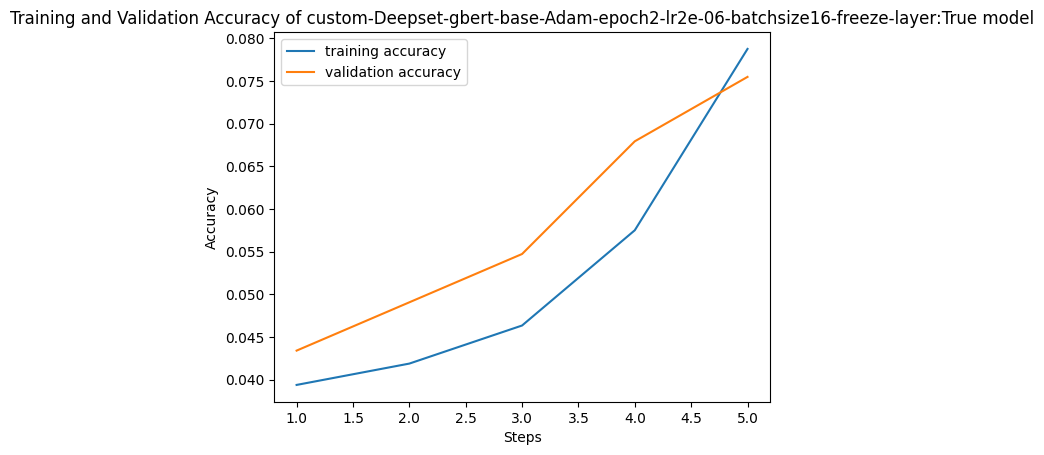

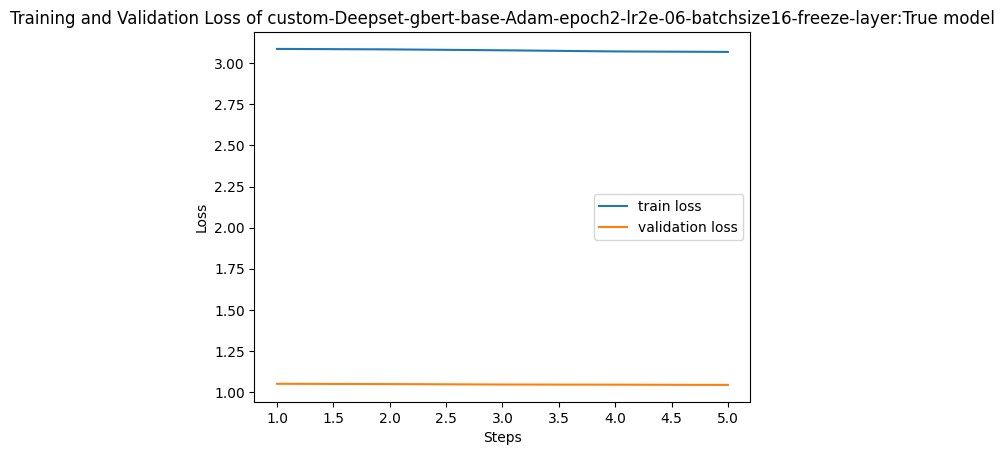

    Label  Correct_preds  Total_preds
0       0              0           28
1       1              5           28
2       2              0           22
3       3             23           24
4       4              0           26
5       5              0           24
6       6              0           24
7       7              0           24
8       8              1           27
9       9              0           24
10     10              5           23
11     11              0           20
12     12              0           20
13     13              0           28
14     14              0           24
15     15              0           29
16     16              0           25
17     17              0           21
18     18              0           18
19     19              6           26
20     20              0           26
21     21              0           19



Hyperparameters: 
 ('Adam', 'lr2e-06', 'batchsize16', 'epoch2') 

Start Training of custom-Xlm-roberta-base-Adam-epoch2-lr2

Some weights of the model checkpoint at Xlm-roberta-base were not used when initializing BertForPreTraining: ['roberta.encoder.layer.4.intermediate.dense.weight', 'roberta.encoder.layer.11.output.dense.bias', 'roberta.encoder.layer.5.attention.self.key.weight', 'roberta.encoder.layer.7.attention.self.key.bias', 'roberta.encoder.layer.10.attention.self.query.weight', 'roberta.encoder.layer.3.attention.output.LayerNorm.weight', 'roberta.encoder.layer.10.attention.self.key.weight', 'roberta.encoder.layer.3.output.LayerNorm.bias', 'roberta.encoder.layer.7.attention.output.LayerNorm.weight', 'roberta.encoder.layer.9.attention.self.query.bias', 'roberta.encoder.layer.11.attention.self.value.weight', 'roberta.encoder.layer.6.output.dense.weight', 'roberta.encoder.layer.7.output.dense.weight', 'roberta.encoder.layer.8.attention.self.key.bias', 'roberta.encoder.layer.9.attention.self.value.weight', 'lm_head.layer_norm.bias', 'roberta.encoder.layer.11.output.LayerNorm.weight', 'roberta.encoder.l

Some weights of BertForPreTraining were not initialized from the model checkpoint at Xlm-roberta-base and are newly initialized: ['encoder.layer.2.output.LayerNorm.bias', 'encoder.layer.1.output.dense.bias', 'encoder.layer.5.output.LayerNorm.bias', 'encoder.layer.9.attention.self.key.bias', 'encoder.layer.10.attention.self.key.bias', 'encoder.layer.10.output.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'cls.predictions.bias', 'encoder.layer.5.attention.output.dense.bias', 'encoder.layer.2.intermediate.dense.bias', 'encoder.layer.7.attention.output.LayerNorm.weight', 'encoder.layer.2.attention.self.key.bias', 'encoder.layer.0.output.dense.bias', 'encoder.layer.10.attention.output.LayerNorm.weight', 'encoder.layer.6.attention.output.LayerNorm.weight', 'encoder.layer.7.attention.self.key.weight', 'encoder.layer.1.attention.self.key.weight', 'encoder.layer.6.output.LayerNorm.weight', 'encoder.layer.1.attention.output.LayerNorm.weight', 'encoder.layer.3.attention.self.key.bias'

Epoch:  1


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.052830188679245285 
100/34 val loss: 1.0503160643577576 
100/298 train accuracy: 0.045 
100/298 train loss: 4.093760743141175 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.052830188679245285 
100/34 val loss: 1.0505220651626588 
100/298 train accuracy: 0.043125 
100/298 train loss: 4.090231249332428 
Epoch:  2


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.052830188679245285 
100/34 val loss: 1.04989976644516 
100/298 train accuracy: 0.05134627426424546 
100/298 train loss: 4.090323827266693 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.052830188679245285 
100/34 val loss: 1.0500911140441895 
100/298 train accuracy: 0.046875 
100/298 train loss: 4.088951034545898 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.052830188679245285 
100/34 val loss: 1.0495092463493347 
100/298 train accuracy: 0.0525 
100/298 train loss: 4.087096230983734 
0.052830188679245285


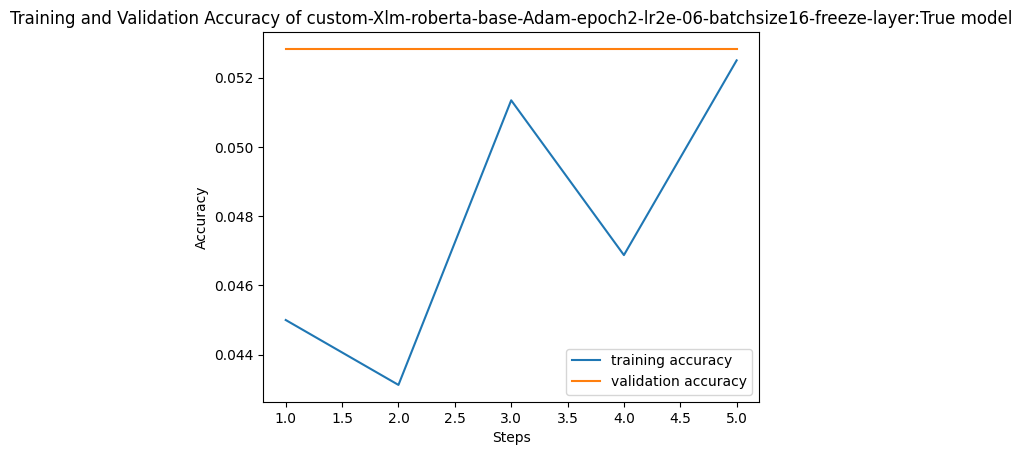

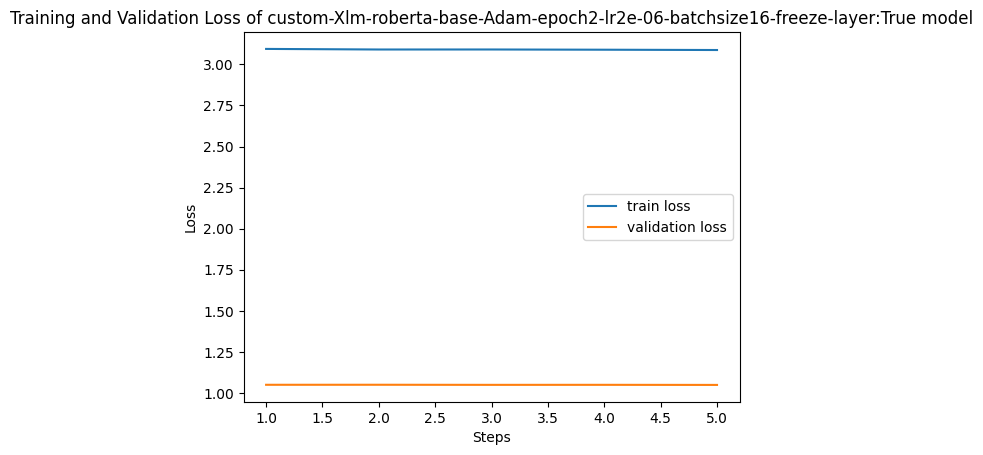

    Label  Correct_preds  Total_preds
0       0              0           28
1       1             28           28
2       2              0           22
3       3              0           24
4       4              0           26
5       5              0           24
6       6              0           24
7       7              0           24
8       8              0           27
9       9              0           24
10     10              0           23
11     11              0           20
12     12              0           20
13     13              0           28
14     14              0           24
15     15              0           29
16     16              0           25
17     17              0           21
18     18              0           18
19     19              0           26
20     20              0           26
21     21              0           19



Hyperparameters: 
 ('Adam', 'lr2e-06', 'batchsize16', 'epoch2') 

Start Training of custom-Uklfr-gottbert-base-Adam-epoch2-

Some weights of the model checkpoint at Uklfr/gottbert-base were not used when initializing BertForPreTraining: ['roberta.encoder.layer.4.intermediate.dense.weight', 'roberta.encoder.layer.11.output.dense.bias', 'roberta.encoder.layer.5.attention.self.key.weight', 'roberta.encoder.layer.7.attention.self.key.bias', 'roberta.encoder.layer.10.attention.self.query.weight', 'roberta.encoder.layer.3.attention.output.LayerNorm.weight', 'roberta.encoder.layer.10.attention.self.key.weight', 'roberta.encoder.layer.3.output.LayerNorm.bias', 'roberta.encoder.layer.7.attention.output.LayerNorm.weight', 'roberta.encoder.layer.9.attention.self.query.bias', 'roberta.encoder.layer.11.attention.self.value.weight', 'roberta.encoder.layer.6.output.dense.weight', 'roberta.encoder.layer.7.output.dense.weight', 'roberta.encoder.layer.8.attention.self.key.bias', 'roberta.encoder.layer.9.attention.self.value.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'roberta.encoder.layer.11.output.LayerNorm.

Some weights of BertForPreTraining were not initialized from the model checkpoint at Uklfr/gottbert-base and are newly initialized: ['encoder.layer.2.output.LayerNorm.bias', 'encoder.layer.1.output.dense.bias', 'encoder.layer.5.output.LayerNorm.bias', 'encoder.layer.9.attention.self.key.bias', 'encoder.layer.10.attention.self.key.bias', 'encoder.layer.10.output.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'cls.predictions.bias', 'encoder.layer.5.attention.output.dense.bias', 'encoder.layer.2.intermediate.dense.bias', 'encoder.layer.7.attention.output.LayerNorm.weight', 'encoder.layer.2.attention.self.key.bias', 'encoder.layer.0.output.dense.bias', 'encoder.layer.10.attention.output.LayerNorm.weight', 'encoder.layer.6.attention.output.LayerNorm.weight', 'encoder.layer.7.attention.self.key.weight', 'encoder.layer.1.attention.self.key.weight', 'encoder.layer.6.output.LayerNorm.weight', 'encoder.layer.1.attention.output.LayerNorm.weight', 'encoder.layer.3.attention.self.key.bi

Epoch:  1


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.04339622641509434 
100/34 val loss: 1.0502514791488649 
100/298 train accuracy: 0.035625 
100/298 train loss: 4.092403612136841 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.04716981132075472 
100/34 val loss: 1.0499038410186767 
100/298 train accuracy: 0.045 
100/298 train loss: 4.0909732055664065 
Epoch:  2


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.04716981132075472 
100/34 val loss: 1.0495709490776062 
100/298 train accuracy: 0.051972448340638695 
100/298 train loss: 4.087825536727905 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.04716981132075472 
100/34 val loss: 1.0503152155876159 
100/298 train accuracy: 0.054375 
100/298 train loss: 4.08733226776123 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.04716981132075472 
100/34 val loss: 1.0494049549102784 
100/298 train accuracy: 0.050625 
100/298 train loss: 4.089148471355438 
0.04716981132075472


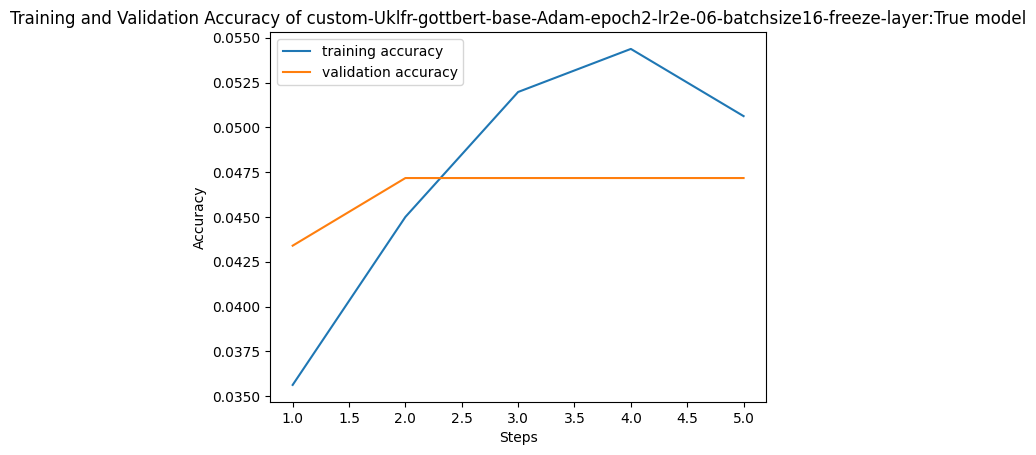

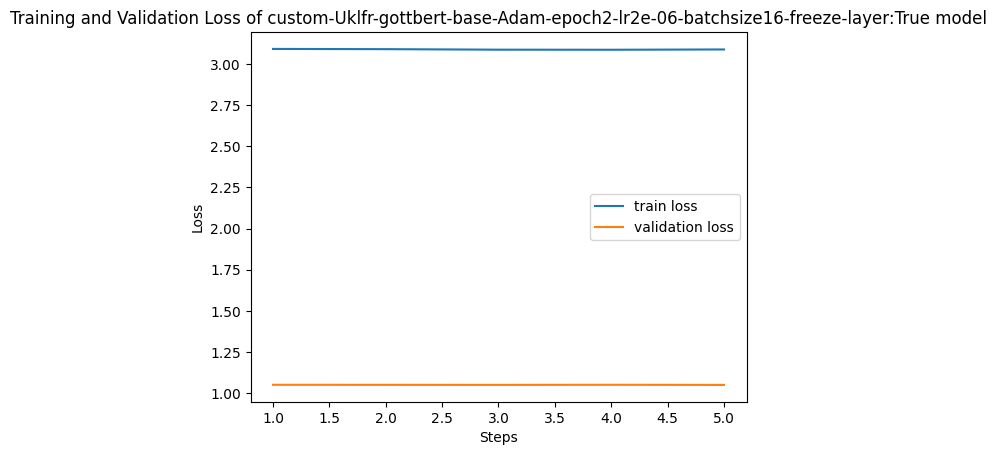

    Label  Correct_preds  Total_preds
0       0              0           28
1       1              0           28
2       2              0           22
3       3              0           24
4       4              0           26
5       5              0           24
6       6              0           24
7       7              0           24
8       8              0           27
9       9              0           24
10     10             23           23
11     11              0           20
12     12              0           20
13     13              0           28
14     14              0           24
15     15              2           29
16     16              0           25
17     17              0           21
18     18              0           18
19     19              0           26
20     20              0           26
21     21              0           19



╒═════════════════════════════════════════════════════════════════════════════════════════╤══════════╤═══════════╤════════╤

In [18]:
""" this code will run the models without custom head.
this can be alter by changing the custom head from True to False.
the weights of the base model is currently freeeze that 
can be unfreezed by changing the freeze layers from True to False """

trained_models_file = 'trained_models.txt'
best_params_dict_path = 'best_params.json'

df = pickle.load(open('dataset/230130_SmallOberkategorie.pickle', 'rb'))
label_names = df['labels'].unique()
# label_names

X = df[['text']]
y = df['labels']
X_train, X_val, y_train, y_val = split_df(X, y)

custom_head = False
freeze_layers = True
optimizers = [Adam]
learning_rates = [2e-6]
epochs = [2]
batch_sizes = [16]

configs =     {'custom_head': custom_head, 'freeze_layers': freeze_layers,
               'optimizers': optimizers, 'epochs': epochs, 'batch_sizes': batch_sizes,
               'learning_rates': learning_rates, 'val_steps':100}
dataset = {'X_train': X_train, 'y_train': y_train, 'X_val': X_val, 'y_val': y_val}

models = [
    'Bert-base-german-cased', 
'Dbmdz/bert-base-german-uncased',
'Deepset/gbert-base',
'Xlm-roberta-base',
'Uklfr/gottbert-base'
]

# training without custom head
training(models, configs, dataset)

# training with custom head
configs['custom_head'] = True
training(models, configs, dataset)

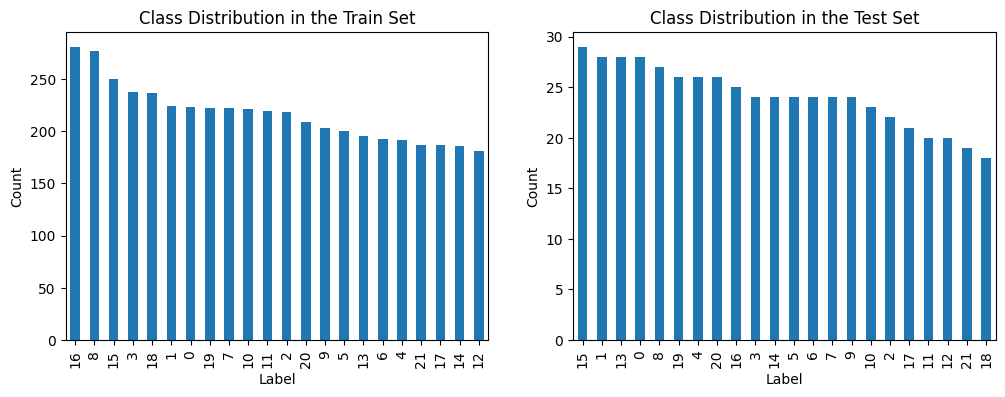

Hyperparameters: 
 ('Adam', 'lr2e-06', 'batchsize16', 'epoch2') 

Start Training of base-Bert-base-german-cased-Adam-epoch2-lr2e-06-batchsize16-freeze-layer:False
Epoch:  1


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.38113207547169814 
100/34 val loss: 0.8804850995540618 
100/298 train accuracy: 0.20125 
100/298 train loss: 3.898561816215515 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.5037735849056604 
100/34 val loss: 0.688064171075821 
100/298 train accuracy: 0.42125 
100/298 train loss: 3.3538288068771362 
Epoch:  2


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.5867924528301887 
100/34 val loss: 0.5761344116926194 
100/298 train accuracy: 0.5554164057608015 
100/298 train loss: 2.873378463983536 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.6283018867924528 
100/34 val loss: 0.5227042710781098 
100/298 train accuracy: 0.62 
100/298 train loss: 2.575615808963776 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.6377358490566037 
100/34 val loss: 0.49838512420654296 
100/298 train accuracy: 0.639375 
100/298 train loss: 2.5357984364032746 
0.6377358490566037


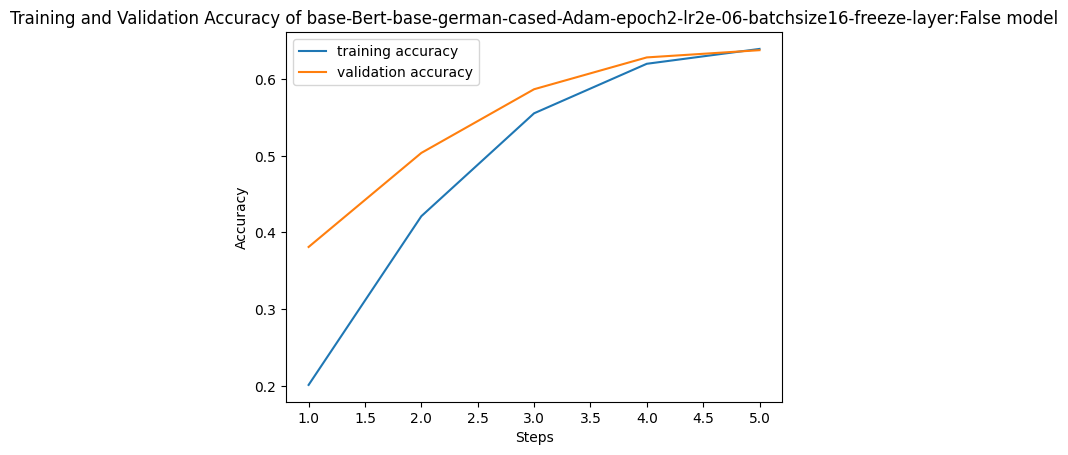

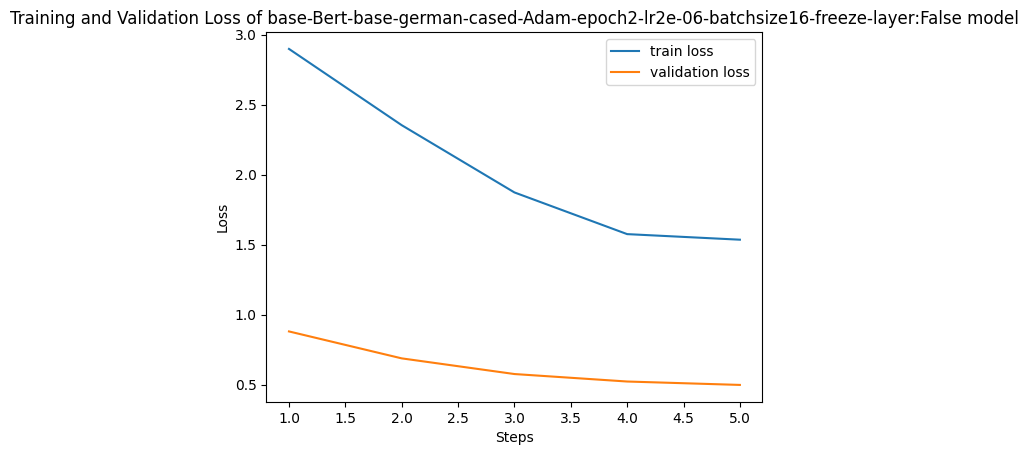

    Label  Correct_preds  Total_preds
0       0             25           28
1       1             28           28
2       2             18           22
3       3             17           24
4       4             25           26
5       5             22           24
6       6              7           24
7       7              0           24
8       8             24           27
9       9             10           24
10     10             21           23
11     11              9           20
12     12              5           20
13     13              5           28
14     14             15           24
15     15             16           29
16     16             25           25
17     17             20           21
18     18              3           18
19     19             12           26
20     20             21           26
21     21             10           19



Hyperparameters: 
 ('SGD', 'lr2e-06', 'batchsize16', 'epoch2') 

Start Training of base-Bert-base-german-cased-SGD-epoch2-l

Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.6509433962264151 
100/34 val loss: 0.4793857371807098 
100/298 train accuracy: 0.64 
100/298 train loss: 2.667005741596222 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.6509433962264151 
100/34 val loss: 0.48920948266983033 
100/298 train accuracy: 0.69 
100/298 train loss: 2.40988245844841 
Epoch:  2


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.6509433962264151 
100/34 val loss: 0.48689191341400145 
100/298 train accuracy: 0.6869129618033814 
100/298 train loss: 2.405122327208519 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.6509433962264151 
100/34 val loss: 0.4873425042629242 
100/298 train accuracy: 0.689375 
100/298 train loss: 2.3700304317474368 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.6509433962264151 
100/34 val loss: 0.4898755520582199 
100/298 train accuracy: 0.678125 
100/298 train loss: 2.452228510379791 
0.6509433962264151


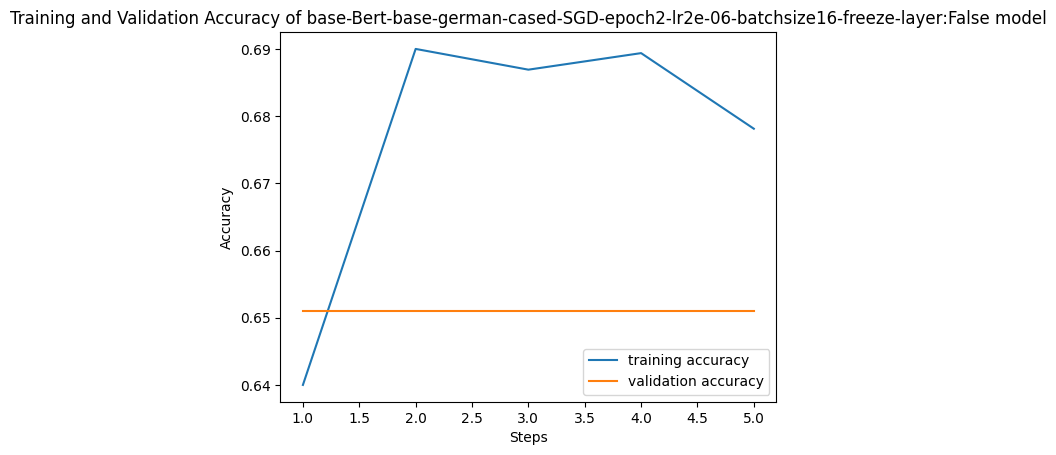

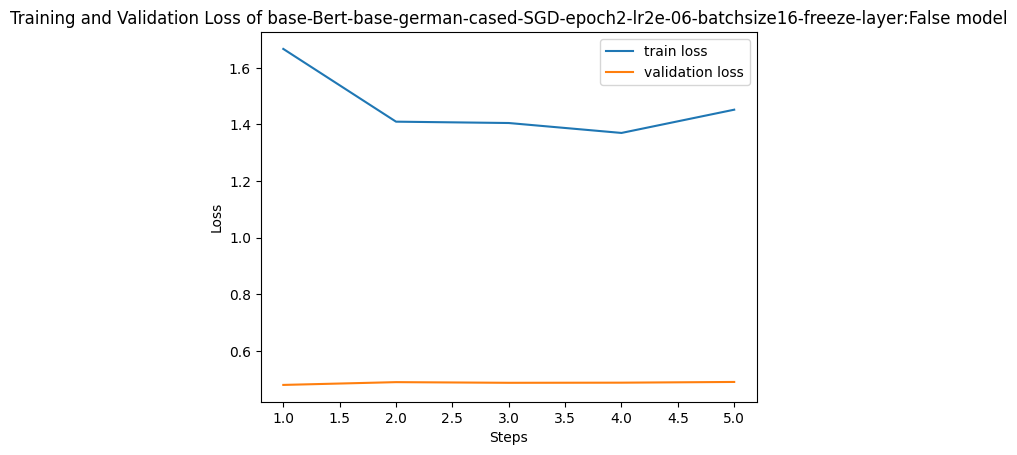

    Label  Correct_preds  Total_preds
0       0             25           28
1       1             28           28
2       2             18           22
3       3             18           24
4       4             25           26
5       5             22           24
6       6              7           24
7       7              0           24
8       8             25           27
9       9             12           24
10     10             21           23
11     11             10           20
12     12              4           20
13     13              5           28
14     14             16           24
15     15             17           29
16     16             25           25
17     17             20           21
18     18              3           18
19     19             13           26
20     20             22           26
21     21              9           19



Hyperparameters: 
 ('Adam', 'lr2e-06', 'batchsize16', 'epoch2') 

Start Training of base-Dbmdz-bert-base-german-uncased-Ada

Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.31886792452830187 
100/34 val loss: 0.9549839782714844 
100/298 train accuracy: 0.120625 
100/298 train loss: 4.009953846931458 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.40943396226415096 
100/34 val loss: 0.8012058234214783 
100/298 train accuracy: 0.34625 
100/298 train loss: 3.6168153405189516 
Epoch:  2


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.45660377358490567 
100/34 val loss: 0.6987682723999024 
100/298 train accuracy: 0.44207889793362554 
100/298 train loss: 3.2333782017230988 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.5169811320754717 
100/34 val loss: 0.638672046661377 
100/298 train accuracy: 0.5125 
100/298 train loss: 2.9321645247936248 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.5339622641509434 
100/34 val loss: 0.6107554388046265 
100/298 train accuracy: 0.516875 
100/298 train loss: 2.89597993016243 
0.5339622641509434


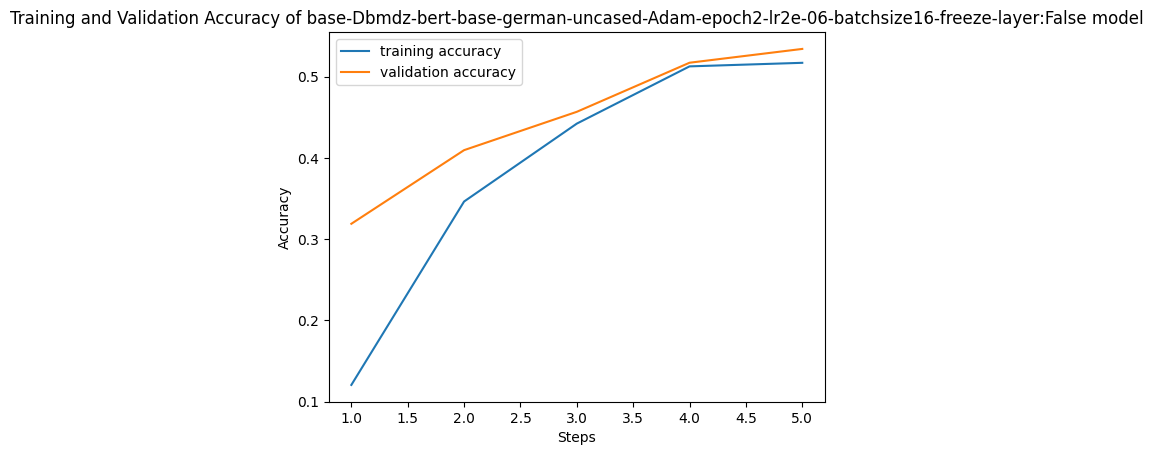

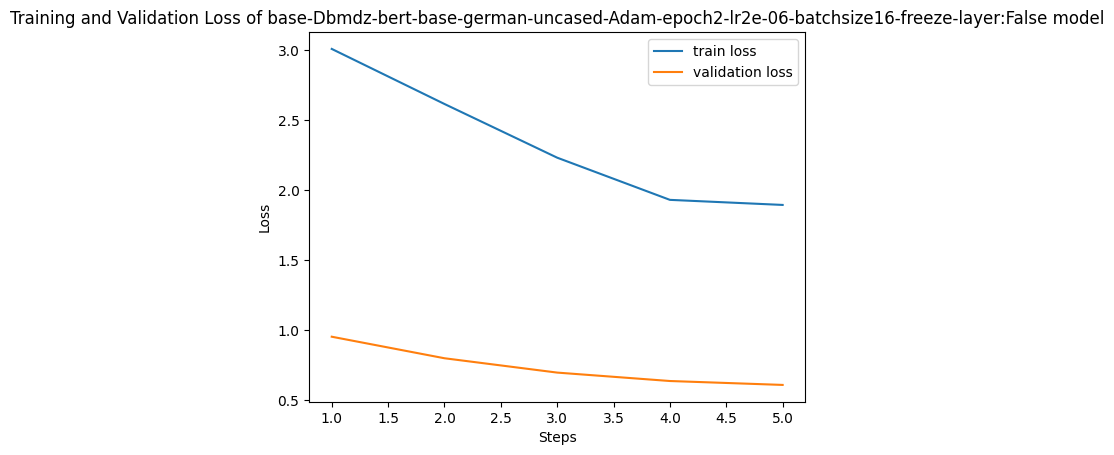

    Label  Correct_preds  Total_preds
0       0             25           28
1       1             28           28
2       2             18           22
3       3              9           24
4       4             25           26
5       5             22           24
6       6              6           24
7       7              4           24
8       8             23           27
9       9              0           24
10     10             21           23
11     11              9           20
12     12              0           20
13     13              4           28
14     14             11           24
15     15              4           29
16     16             25           25
17     17             20           21
18     18              3           18
19     19              4           26
20     20             18           26
21     21              4           19



Hyperparameters: 
 ('SGD', 'lr2e-06', 'batchsize16', 'epoch2') 

Start Training of base-Dbmdz-bert-base-german-uncased-SGD-

Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.539622641509434 
100/34 val loss: 0.5957474660873413 
100/298 train accuracy: 0.50375 
100/298 train loss: 3.109872226715088 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.539622641509434 
100/34 val loss: 0.6009923851490021 
100/298 train accuracy: 0.550625 
100/298 train loss: 2.77190996825695 
Epoch:  2


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.539622641509434 
100/34 val loss: 0.6030895614624023 
100/298 train accuracy: 0.569818409517846 
100/298 train loss: 2.773402580022812 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.539622641509434 
100/34 val loss: 0.6035181093215942 
100/298 train accuracy: 0.573125 
100/298 train loss: 2.722580453157425 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.539622641509434 
100/34 val loss: 0.6014759016036987 
100/298 train accuracy: 0.549375 
100/298 train loss: 2.8144679391384124 
0.539622641509434


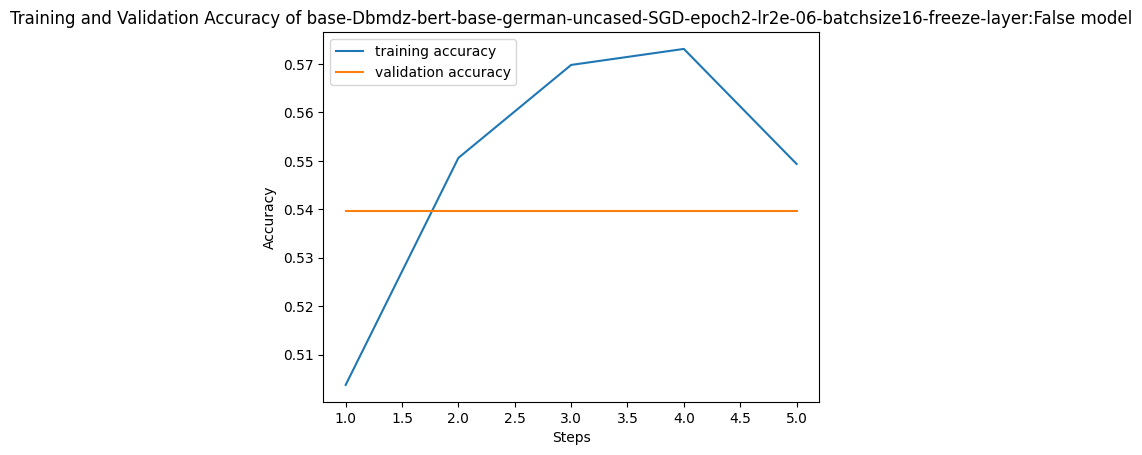

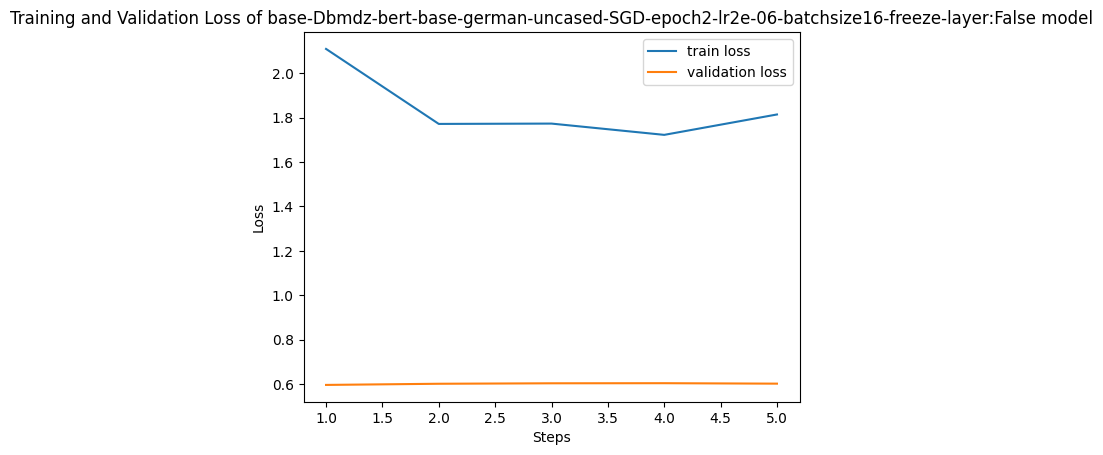

    Label  Correct_preds  Total_preds
0       0             26           28
1       1             28           28
2       2             18           22
3       3             11           24
4       4             25           26
5       5             22           24
6       6              6           24
7       7              3           24
8       8             23           27
9       9              0           24
10     10             20           23
11     11              9           20
12     12              0           20
13     13              4           28
14     14             11           24
15     15              4           29
16     16             25           25
17     17             20           21
18     18              4           18
19     19              4           26
20     20             19           26
21     21              4           19



Hyperparameters: 
 ('Adam', 'lr2e-06', 'batchsize16', 'epoch2') 

Start Training of base-Deepset-gbert-base-Adam-epoch2-lr2

Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.37735849056603776 
100/34 val loss: 0.8916218376159668 
100/298 train accuracy: 0.1875 
100/298 train loss: 3.929575524330139 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.4867924528301887 
100/34 val loss: 0.724143990278244 
100/298 train accuracy: 0.433125 
100/298 train loss: 3.406296843290329 
Epoch:  2


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.5886792452830188 
100/34 val loss: 0.597888275384903 
100/298 train accuracy: 0.5491546649968692 
100/298 train loss: 2.958924103975296 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.6716981132075471 
100/34 val loss: 0.5299040472507477 
100/298 train accuracy: 0.679375 
100/298 train loss: 2.6090118610858917 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.7037735849056603 
100/34 val loss: 0.49365307033061984 
100/298 train accuracy: 0.70125 
100/298 train loss: 2.5204937481880187 
0.7037735849056603


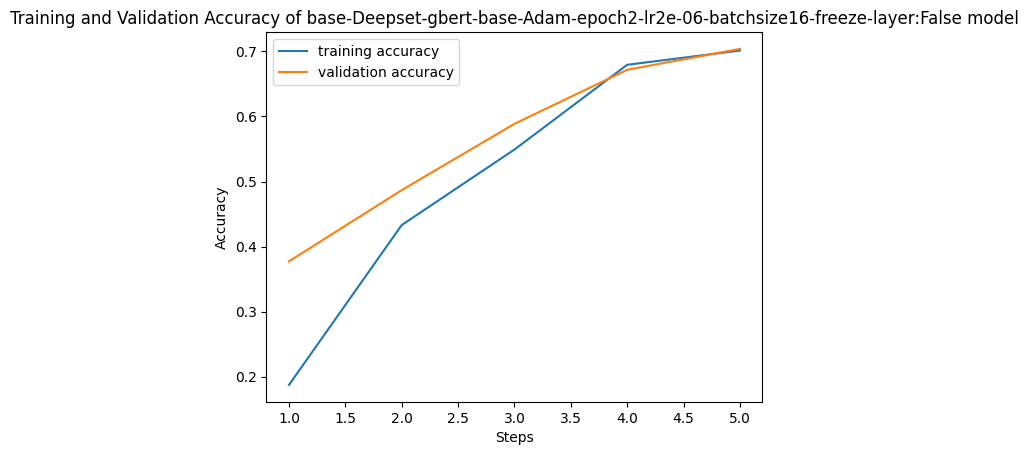

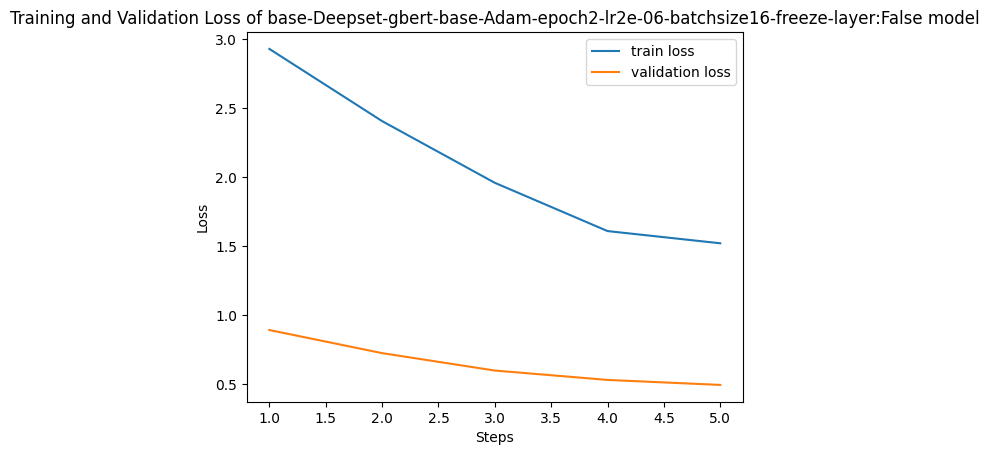

    Label  Correct_preds  Total_preds
0       0             25           28
1       1             28           28
2       2             18           22
3       3             22           24
4       4             25           26
5       5             23           24
6       6             15           24
7       7              3           24
8       8             25           27
9       9              5           24
10     10             22           23
11     11             19           20
12     12              3           20
13     13              5           28
14     14             13           24
15     15             21           29
16     16             25           25
17     17             20           21
18     18             14           18
19     19             14           26
20     20             22           26
21     21              6           19



Hyperparameters: 
 ('SGD', 'lr2e-06', 'batchsize16', 'epoch2') 

Start Training of base-Deepset-gbert-base-SGD-epoch2-lr2e-

Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.7150943396226415 
100/34 val loss: 0.4714286386966705 
100/298 train accuracy: 0.695625 
100/298 train loss: 2.6619181418418885 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.7150943396226415 
100/34 val loss: 0.47881599187850954 
100/298 train accuracy: 0.741875 
100/298 train loss: 2.375813932418823 
Epoch:  2


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.7150943396226415 
100/34 val loss: 0.47581859171390534 
100/298 train accuracy: 0.7582968065122104 
100/298 train loss: 2.3767572551965714 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.7150943396226415 
100/34 val loss: 0.48142493605613706 
100/298 train accuracy: 0.769375 
100/298 train loss: 2.3424960064888003 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.7150943396226415 
100/34 val loss: 0.48200966835021974 
100/298 train accuracy: 0.733125 
100/298 train loss: 2.4170402586460114 
0.7150943396226415


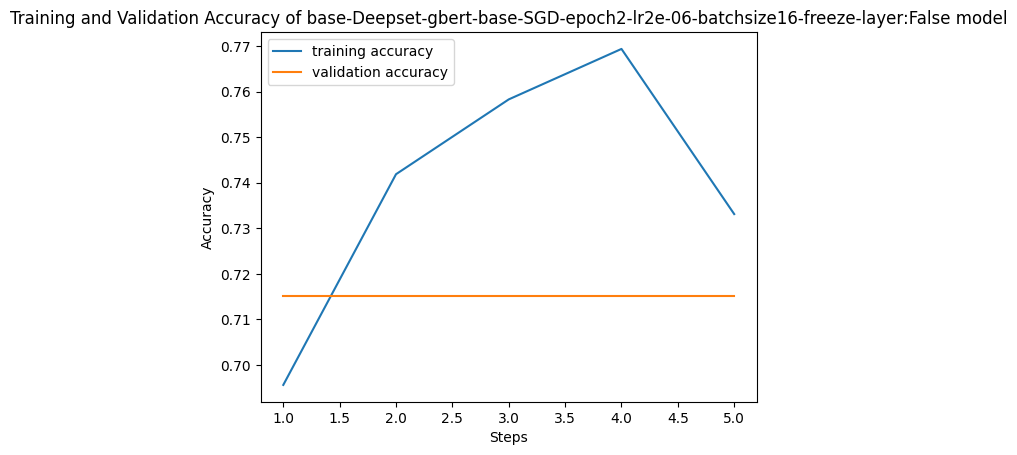

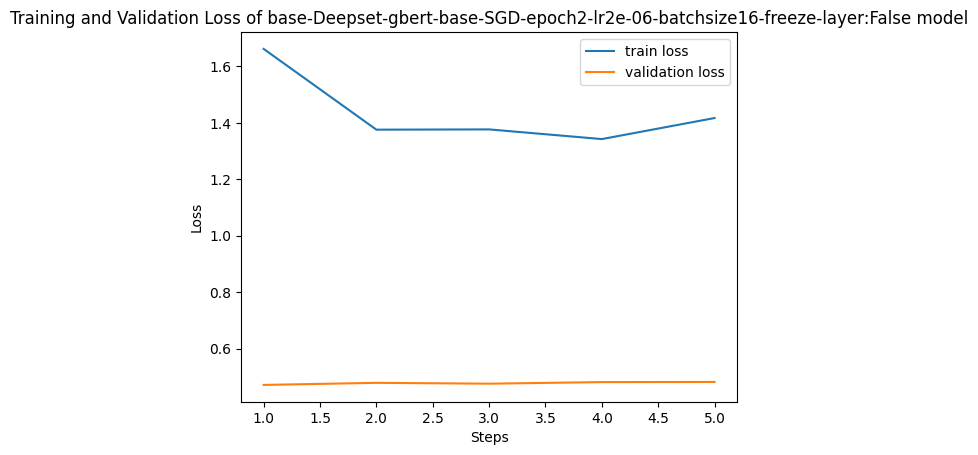

    Label  Correct_preds  Total_preds
0       0             25           28
1       1             28           28
2       2             18           22
3       3             22           24
4       4             25           26
5       5             23           24
6       6             16           24
7       7              3           24
8       8             25           27
9       9              5           24
10     10             22           23
11     11             20           20
12     12              3           20
13     13              6           28
14     14             14           24
15     15             23           29
16     16             25           25
17     17             20           21
18     18             14           18
19     19             15           26
20     20             22           26
21     21              5           19



Hyperparameters: 
 ('Adam', 'lr2e-06', 'batchsize16', 'epoch2') 

Start Training of base-Xlm-roberta-base-Adam-epoch2-lr2e-

Some weights of the model checkpoint at Xlm-roberta-base were not used when initializing BertForPreTraining: ['roberta.encoder.layer.4.intermediate.dense.weight', 'roberta.encoder.layer.11.output.dense.bias', 'roberta.encoder.layer.5.attention.self.key.weight', 'roberta.encoder.layer.7.attention.self.key.bias', 'roberta.encoder.layer.10.attention.self.query.weight', 'roberta.encoder.layer.3.attention.output.LayerNorm.weight', 'roberta.encoder.layer.10.attention.self.key.weight', 'roberta.encoder.layer.3.output.LayerNorm.bias', 'roberta.encoder.layer.7.attention.output.LayerNorm.weight', 'roberta.encoder.layer.9.attention.self.query.bias', 'roberta.encoder.layer.11.attention.self.value.weight', 'roberta.encoder.layer.6.output.dense.weight', 'roberta.encoder.layer.7.output.dense.weight', 'roberta.encoder.layer.8.attention.self.key.bias', 'roberta.encoder.layer.9.attention.self.value.weight', 'lm_head.layer_norm.bias', 'roberta.encoder.layer.11.output.LayerNorm.weight', 'roberta.encoder.l

Some weights of BertForPreTraining were not initialized from the model checkpoint at Xlm-roberta-base and are newly initialized: ['encoder.layer.2.output.LayerNorm.bias', 'encoder.layer.1.output.dense.bias', 'encoder.layer.5.output.LayerNorm.bias', 'encoder.layer.9.attention.self.key.bias', 'encoder.layer.10.attention.self.key.bias', 'encoder.layer.10.output.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'cls.predictions.bias', 'encoder.layer.5.attention.output.dense.bias', 'encoder.layer.2.intermediate.dense.bias', 'encoder.layer.7.attention.output.LayerNorm.weight', 'encoder.layer.2.attention.self.key.bias', 'encoder.layer.0.output.dense.bias', 'encoder.layer.10.attention.output.LayerNorm.weight', 'encoder.layer.6.attention.output.LayerNorm.weight', 'encoder.layer.7.attention.self.key.weight', 'encoder.layer.1.attention.self.key.weight', 'encoder.layer.6.output.LayerNorm.weight', 'encoder.layer.1.attention.output.LayerNorm.weight', 'encoder.layer.3.attention.self.key.bias'

Epoch:  1


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.08867924528301886 
100/34 val loss: 1.0443049693107604 
100/298 train accuracy: 0.05625 
100/298 train loss: 4.133489143848419 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.1641509433962264 
100/34 val loss: 1.0145231890678406 
100/298 train accuracy: 0.096875 
100/298 train loss: 4.027581350803375 
Epoch:  2


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.15283018867924528 
100/34 val loss: 0.9831686782836914 
100/298 train accuracy: 0.1527864746399499 
100/298 train loss: 3.939983968734741 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.24716981132075472 
100/34 val loss: 0.9472193861007691 
100/298 train accuracy: 0.244375 
100/298 train loss: 3.834031648635864 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.3490566037735849 
100/34 val loss: 0.9177244687080384 
100/298 train accuracy: 0.27375 
100/298 train loss: 3.7543994641304015 
0.3490566037735849


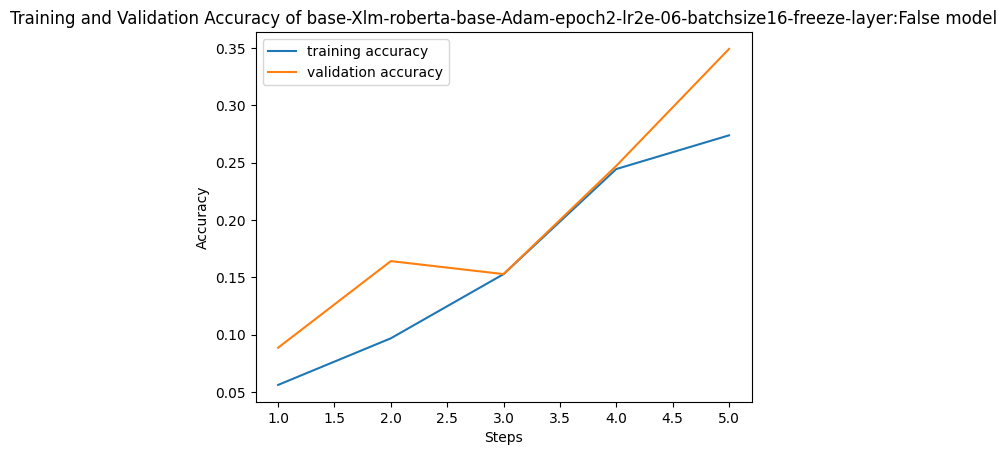

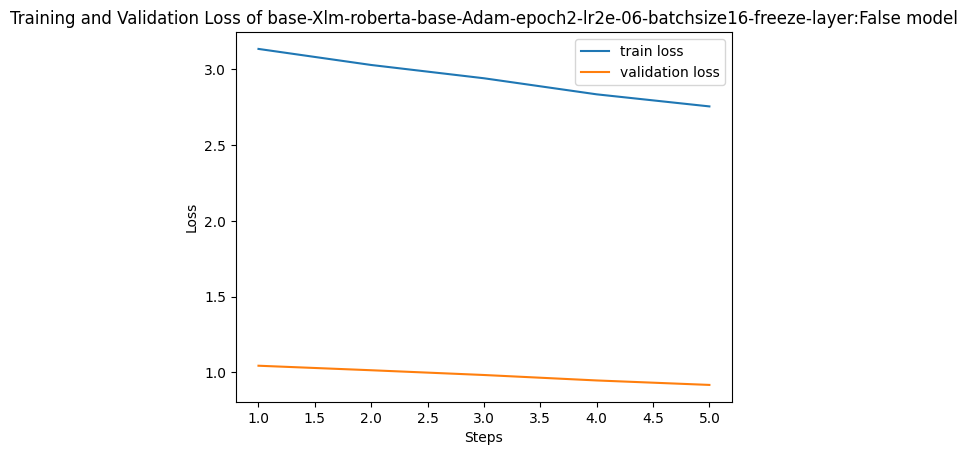

    Label  Correct_preds  Total_preds
0       0              0           28
1       1             28           28
2       2             18           22
3       3              9           24
4       4             24           26
5       5             22           24
6       6              0           24
7       7              2           24
8       8             25           27
9       9              0           24
10     10             22           23
11     11              0           20
12     12              1           20
13     13              4           28
14     14              1           24
15     15              0           29
16     16             22           25
17     17              0           21
18     18              1           18
19     19              6           26
20     20              0           26
21     21              0           19



Hyperparameters: 
 ('SGD', 'lr2e-06', 'batchsize16', 'epoch2') 

Start Training of base-Xlm-roberta-base-SGD-epoch2-lr2e-06

Some weights of the model checkpoint at Xlm-roberta-base were not used when initializing BertForPreTraining: ['roberta.encoder.layer.4.intermediate.dense.weight', 'roberta.encoder.layer.11.output.dense.bias', 'roberta.encoder.layer.5.attention.self.key.weight', 'roberta.encoder.layer.7.attention.self.key.bias', 'roberta.encoder.layer.10.attention.self.query.weight', 'roberta.encoder.layer.3.attention.output.LayerNorm.weight', 'roberta.encoder.layer.10.attention.self.key.weight', 'roberta.encoder.layer.3.output.LayerNorm.bias', 'roberta.encoder.layer.7.attention.output.LayerNorm.weight', 'roberta.encoder.layer.9.attention.self.query.bias', 'roberta.encoder.layer.11.attention.self.value.weight', 'roberta.encoder.layer.6.output.dense.weight', 'roberta.encoder.layer.7.output.dense.weight', 'roberta.encoder.layer.8.attention.self.key.bias', 'roberta.encoder.layer.9.attention.self.value.weight', 'lm_head.layer_norm.bias', 'roberta.encoder.layer.11.output.LayerNorm.weight', 'roberta.encoder.l

Some weights of BertForPreTraining were not initialized from the model checkpoint at Xlm-roberta-base and are newly initialized: ['encoder.layer.2.output.LayerNorm.bias', 'encoder.layer.1.output.dense.bias', 'encoder.layer.5.output.LayerNorm.bias', 'encoder.layer.9.attention.self.key.bias', 'encoder.layer.10.attention.self.key.bias', 'encoder.layer.10.output.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'cls.predictions.bias', 'encoder.layer.5.attention.output.dense.bias', 'encoder.layer.2.intermediate.dense.bias', 'encoder.layer.7.attention.output.LayerNorm.weight', 'encoder.layer.2.attention.self.key.bias', 'encoder.layer.0.output.dense.bias', 'encoder.layer.10.attention.output.LayerNorm.weight', 'encoder.layer.6.attention.output.LayerNorm.weight', 'encoder.layer.7.attention.self.key.weight', 'encoder.layer.1.attention.self.key.weight', 'encoder.layer.6.output.LayerNorm.weight', 'encoder.layer.1.attention.output.LayerNorm.weight', 'encoder.layer.3.attention.self.key.bias'

Epoch:  1


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.4 
100/34 val loss: 0.9021840929985047 
100/298 train accuracy: 0.261875 
100/298 train loss: 3.731587836742401 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.4 
100/34 val loss: 0.9070171809196472 
100/298 train accuracy: 0.405 
100/298 train loss: 3.6720364189147947 
Epoch:  2


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.4 
100/34 val loss: 0.9067356586456299 
100/298 train accuracy: 0.3882279273638071 
100/298 train loss: 3.6724102544784545 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.4 
100/34 val loss: 0.9082382726669311 
100/298 train accuracy: 0.4125 
100/298 train loss: 3.6568064451217652 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.4 
100/34 val loss: 0.9034110689163208 
100/298 train accuracy: 0.38625 
100/298 train loss: 3.684356381893158 
0.4


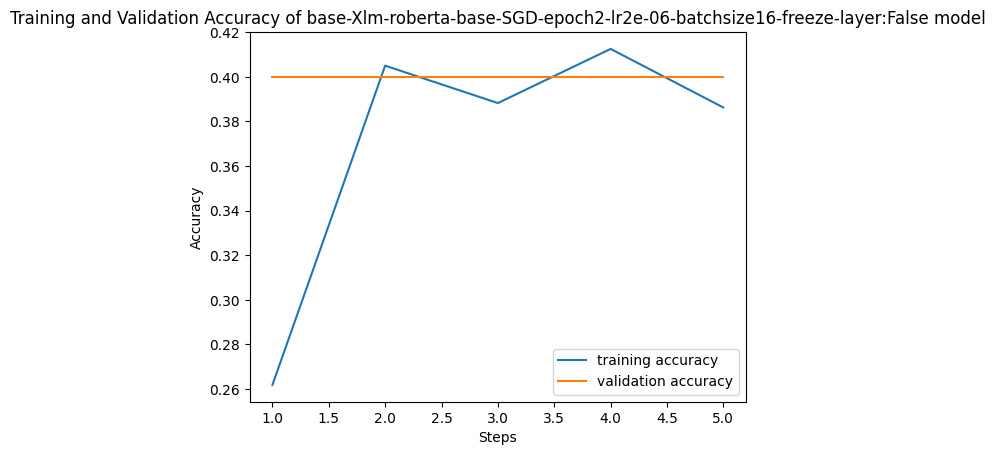

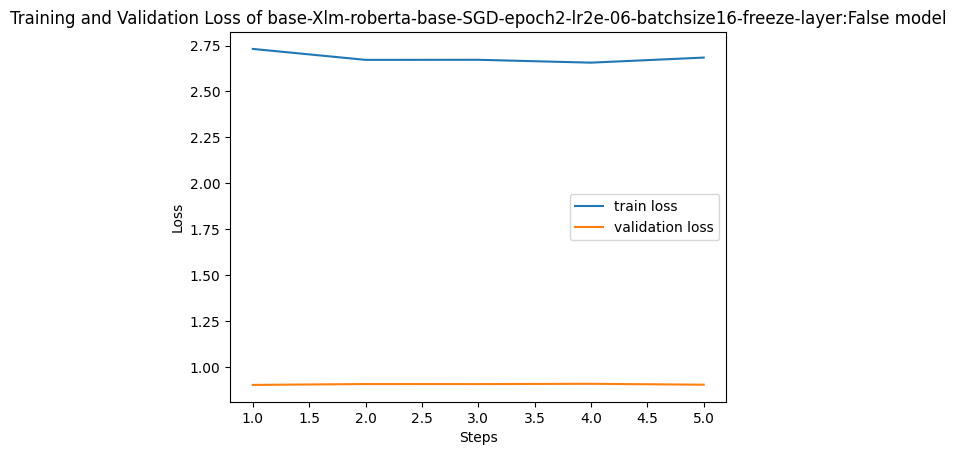

    Label  Correct_preds  Total_preds
0       0             24           28
1       1             28           28
2       2             18           22
3       3              7           24
4       4             25           26
5       5             22           24
6       6              0           24
7       7              0           24
8       8             21           27
9       9              0           24
10     10             16           23
11     11              0           20
12     12              0           20
13     13              4           28
14     14              1           24
15     15              5           29
16     16             25           25
17     17              0           21
18     18              4           18
19     19              6           26
20     20              6           26
21     21              0           19



Hyperparameters: 
 ('Adam', 'lr2e-06', 'batchsize16', 'epoch2') 

Start Training of base-Uklfr-gottbert-base-Adam-epoch2-lr

Some weights of the model checkpoint at Uklfr/gottbert-base were not used when initializing BertForPreTraining: ['roberta.encoder.layer.4.intermediate.dense.weight', 'roberta.encoder.layer.11.output.dense.bias', 'roberta.encoder.layer.5.attention.self.key.weight', 'roberta.encoder.layer.7.attention.self.key.bias', 'roberta.encoder.layer.10.attention.self.query.weight', 'roberta.encoder.layer.3.attention.output.LayerNorm.weight', 'roberta.encoder.layer.10.attention.self.key.weight', 'roberta.encoder.layer.3.output.LayerNorm.bias', 'roberta.encoder.layer.7.attention.output.LayerNorm.weight', 'roberta.encoder.layer.9.attention.self.query.bias', 'roberta.encoder.layer.11.attention.self.value.weight', 'roberta.encoder.layer.6.output.dense.weight', 'roberta.encoder.layer.7.output.dense.weight', 'roberta.encoder.layer.8.attention.self.key.bias', 'roberta.encoder.layer.9.attention.self.value.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'roberta.encoder.layer.11.output.LayerNorm.

Some weights of BertForPreTraining were not initialized from the model checkpoint at Uklfr/gottbert-base and are newly initialized: ['encoder.layer.2.output.LayerNorm.bias', 'encoder.layer.1.output.dense.bias', 'encoder.layer.5.output.LayerNorm.bias', 'encoder.layer.9.attention.self.key.bias', 'encoder.layer.10.attention.self.key.bias', 'encoder.layer.10.output.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'cls.predictions.bias', 'encoder.layer.5.attention.output.dense.bias', 'encoder.layer.2.intermediate.dense.bias', 'encoder.layer.7.attention.output.LayerNorm.weight', 'encoder.layer.2.attention.self.key.bias', 'encoder.layer.0.output.dense.bias', 'encoder.layer.10.attention.output.LayerNorm.weight', 'encoder.layer.6.attention.output.LayerNorm.weight', 'encoder.layer.7.attention.self.key.weight', 'encoder.layer.1.attention.self.key.weight', 'encoder.layer.6.output.LayerNorm.weight', 'encoder.layer.1.attention.output.LayerNorm.weight', 'encoder.layer.3.attention.self.key.bi

Epoch:  1


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.06037735849056604 
100/34 val loss: 1.033548996448517 
100/298 train accuracy: 0.05 
100/298 train loss: 4.121509621143341 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.11132075471698114 
100/34 val loss: 1.0001227498054504 
100/298 train accuracy: 0.1 
100/298 train loss: 3.9982140350341795 
Epoch:  2


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.16792452830188678 
100/34 val loss: 0.9596507334709168 
100/298 train accuracy: 0.17720726361928615 
100/298 train loss: 3.8814450097084046 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.3584905660377358 
100/34 val loss: 0.915666651725769 
100/298 train accuracy: 0.27125 
100/298 train loss: 3.74454598903656 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.2830188679245283 
100/34 val loss: 0.8807117712497711 
100/298 train accuracy: 0.278125 
100/298 train loss: 3.659424569606781 
0.2830188679245283


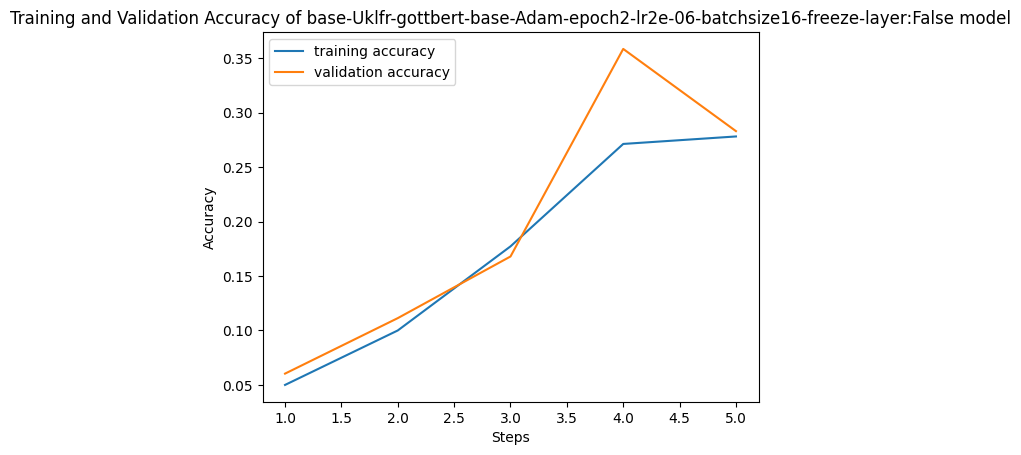

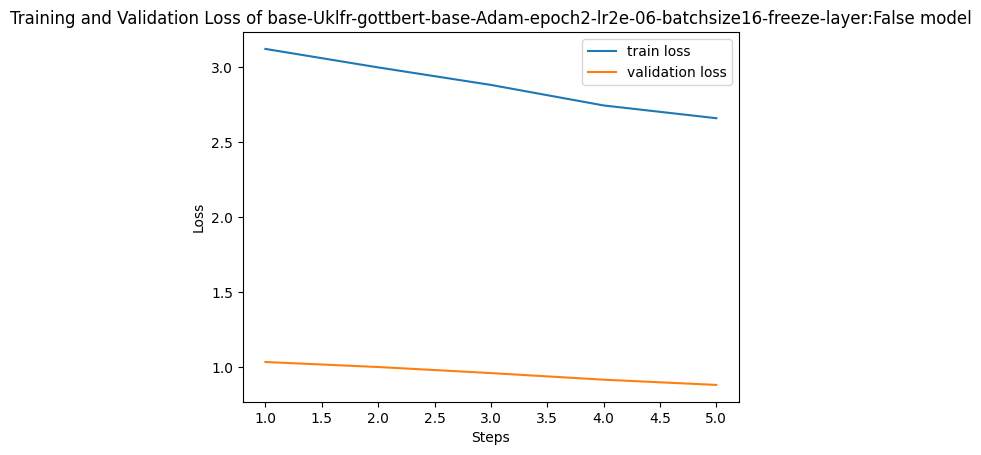

    Label  Correct_preds  Total_preds
0       0              0           28
1       1             28           28
2       2              6           22
3       3             13           24
4       4             24           26
5       5              1           24
6       6              0           24
7       7              0           24
8       8             25           27
9       9              0           24
10     10             22           23
11     11              1           20
12     12              2           20
13     13              4           28
14     14              0           24
15     15              0           29
16     16             22           25
17     17              0           21
18     18              0           18
19     19              2           26
20     20              0           26
21     21              0           19



Hyperparameters: 
 ('SGD', 'lr2e-06', 'batchsize16', 'epoch2') 

Start Training of base-Uklfr-gottbert-base-SGD-epoch2-lr2e

Some weights of the model checkpoint at Uklfr/gottbert-base were not used when initializing BertForPreTraining: ['roberta.encoder.layer.4.intermediate.dense.weight', 'roberta.encoder.layer.11.output.dense.bias', 'roberta.encoder.layer.5.attention.self.key.weight', 'roberta.encoder.layer.7.attention.self.key.bias', 'roberta.encoder.layer.10.attention.self.query.weight', 'roberta.encoder.layer.3.attention.output.LayerNorm.weight', 'roberta.encoder.layer.10.attention.self.key.weight', 'roberta.encoder.layer.3.output.LayerNorm.bias', 'roberta.encoder.layer.7.attention.output.LayerNorm.weight', 'roberta.encoder.layer.9.attention.self.query.bias', 'roberta.encoder.layer.11.attention.self.value.weight', 'roberta.encoder.layer.6.output.dense.weight', 'roberta.encoder.layer.7.output.dense.weight', 'roberta.encoder.layer.8.attention.self.key.bias', 'roberta.encoder.layer.9.attention.self.value.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'roberta.encoder.layer.11.output.LayerNorm.

Some weights of BertForPreTraining were not initialized from the model checkpoint at Uklfr/gottbert-base and are newly initialized: ['encoder.layer.2.output.LayerNorm.bias', 'encoder.layer.1.output.dense.bias', 'encoder.layer.5.output.LayerNorm.bias', 'encoder.layer.9.attention.self.key.bias', 'encoder.layer.10.attention.self.key.bias', 'encoder.layer.10.output.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'cls.predictions.bias', 'encoder.layer.5.attention.output.dense.bias', 'encoder.layer.2.intermediate.dense.bias', 'encoder.layer.7.attention.output.LayerNorm.weight', 'encoder.layer.2.attention.self.key.bias', 'encoder.layer.0.output.dense.bias', 'encoder.layer.10.attention.output.LayerNorm.weight', 'encoder.layer.6.attention.output.LayerNorm.weight', 'encoder.layer.7.attention.self.key.weight', 'encoder.layer.1.attention.self.key.weight', 'encoder.layer.6.output.LayerNorm.weight', 'encoder.layer.1.attention.output.LayerNorm.weight', 'encoder.layer.3.attention.self.key.bi

Epoch:  1


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.36981132075471695 
100/34 val loss: 0.8636751461029053 
100/298 train accuracy: 0.275 
100/298 train loss: 3.647478802204132 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.36981132075471695 
100/34 val loss: 0.8734544491767884 
100/298 train accuracy: 0.3975 
100/298 train loss: 3.57380747795105 
Epoch:  2


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.36981132075471695 
100/34 val loss: 0.8710601663589478 
100/298 train accuracy: 0.4001252348152787 
100/298 train loss: 3.564043605327606 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.36981132075471695 
100/34 val loss: 0.8735428118705749 
100/298 train accuracy: 0.405625 
100/298 train loss: 3.5441515755653383 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.36981132075471695 
100/34 val loss: 0.8667100596427918 
100/298 train accuracy: 0.384375 
100/298 train loss: 3.584679937362671 
0.36981132075471695


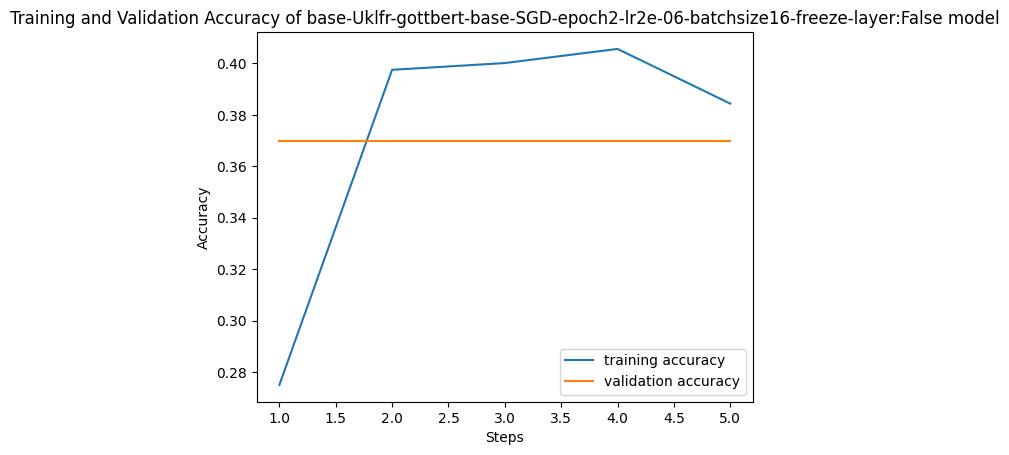

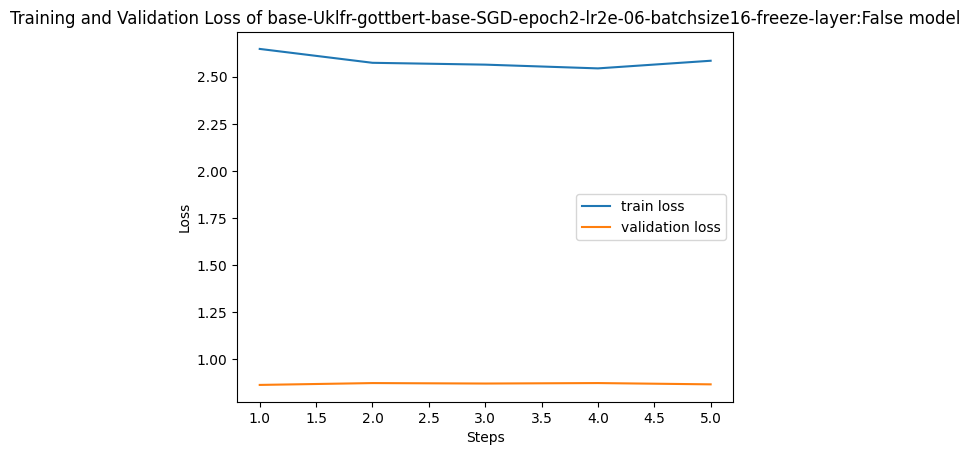

    Label  Correct_preds  Total_preds
0       0             13           28
1       1             28           28
2       2             18           22
3       3              9           24
4       4             25           26
5       5              4           24
6       6              0           24
7       7              1           24
8       8             18           27
9       9              0           24
10     10             21           23
11     11              4           20
12     12              0           20
13     13              4           28
14     14              0           24
15     15              7           29
16     16             25           25
17     17             16           21
18     18              2           18
19     19              1           26
20     20              0           26
21     21              0           19



╒════════════════════════════════════════════════════════════════════════════════════════╤══════════╤═══════════╤════════╤═

Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.30754716981132074 
100/34 val loss: 1.0284602379798888 
100/298 train accuracy: 0.14125 
100/298 train loss: 4.061424341201782 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.360377358490566 
100/34 val loss: 1.003428292274475 
100/298 train accuracy: 0.32875 
100/298 train loss: 3.9970999431610106 
Epoch:  2


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.39811320754716983 
100/34 val loss: 0.9820170879364014 
100/298 train accuracy: 0.37820914214151535 
100/298 train loss: 3.9244416832923887 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.4320754716981132 
100/34 val loss: 0.9659458827972413 
100/298 train accuracy: 0.4325 
100/298 train loss: 3.8590867137908935 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.44528301886792454 
100/34 val loss: 0.9560304188728332 
100/298 train accuracy: 0.43375 
100/298 train loss: 3.8390666961669924 
0.44528301886792454


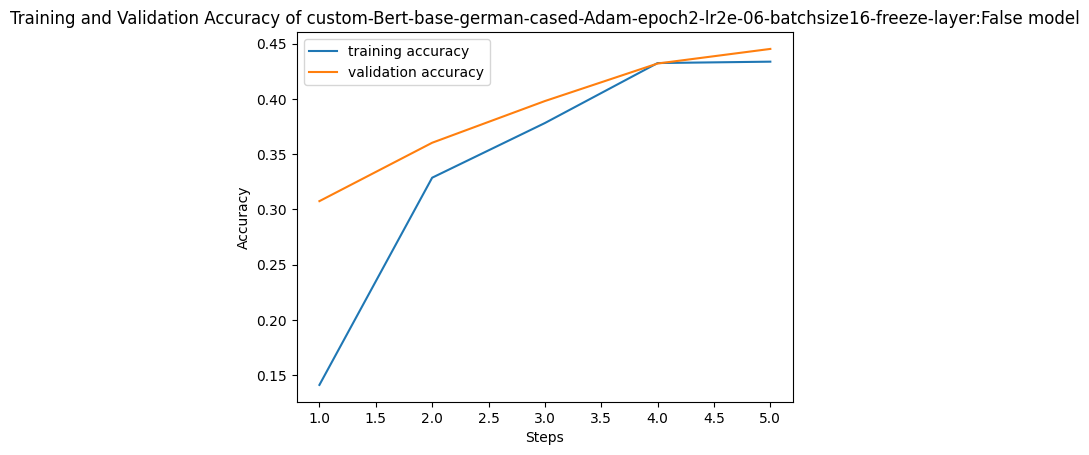

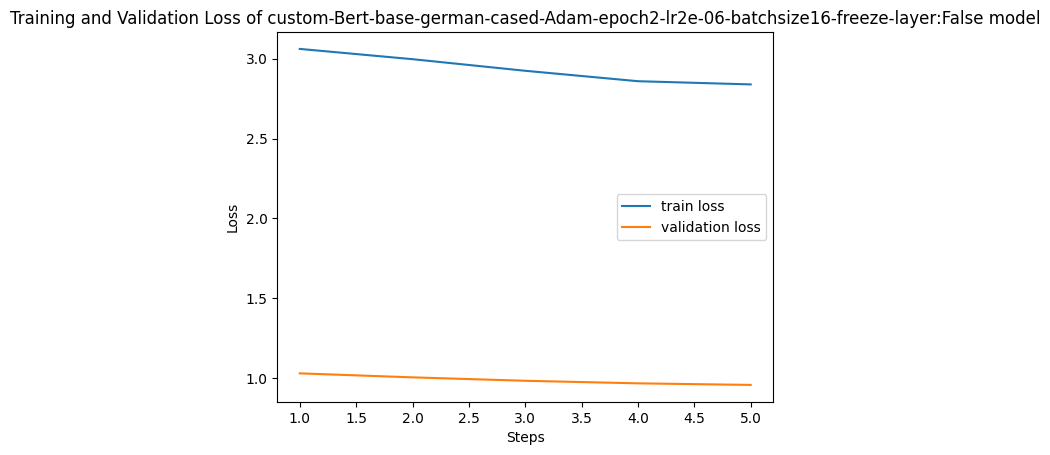

    Label  Correct_preds  Total_preds
0       0              6           28
1       1             28           28
2       2             18           22
3       3             10           24
4       4             25           26
5       5             19           24
6       6              2           24
7       7              0           24
8       8             22           27
9       9             15           24
10     10             21           23
11     11              3           20
12     12              0           20
13     13              0           28
14     14              0           24
15     15             10           29
16     16             25           25
17     17             20           21
18     18              3           18
19     19              0           26
20     20              9           26
21     21              0           19



Hyperparameters: 
 ('SGD', 'lr2e-06', 'batchsize16', 'epoch2') 

Start Training of custom-Bert-base-german-cased-SGD-epoch2

Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.44528301886792454 
100/34 val loss: 0.9521501898765564 
100/298 train accuracy: 0.4225 
100/298 train loss: 3.8875937032699586 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.44528301886792454 
100/34 val loss: 0.9540892100334167 
100/298 train accuracy: 0.480625 
100/298 train loss: 3.8119177842140197 
Epoch:  2


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.44528301886792454 
100/34 val loss: 0.9535661768913269 
100/298 train accuracy: 0.47839699436443334 
100/298 train loss: 3.807778434753418 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.44528301886792454 
100/34 val loss: 0.9541206741333008 
100/298 train accuracy: 0.48625 
100/298 train loss: 3.79807254076004 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.44528301886792454 
100/34 val loss: 0.9530395531654358 
100/298 train accuracy: 0.465 
100/298 train loss: 3.8172229957580566 
0.44528301886792454


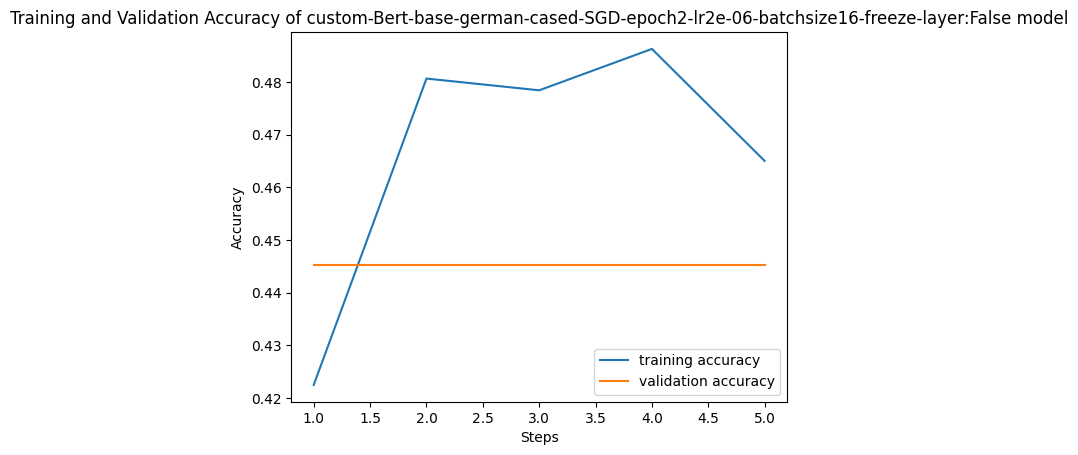

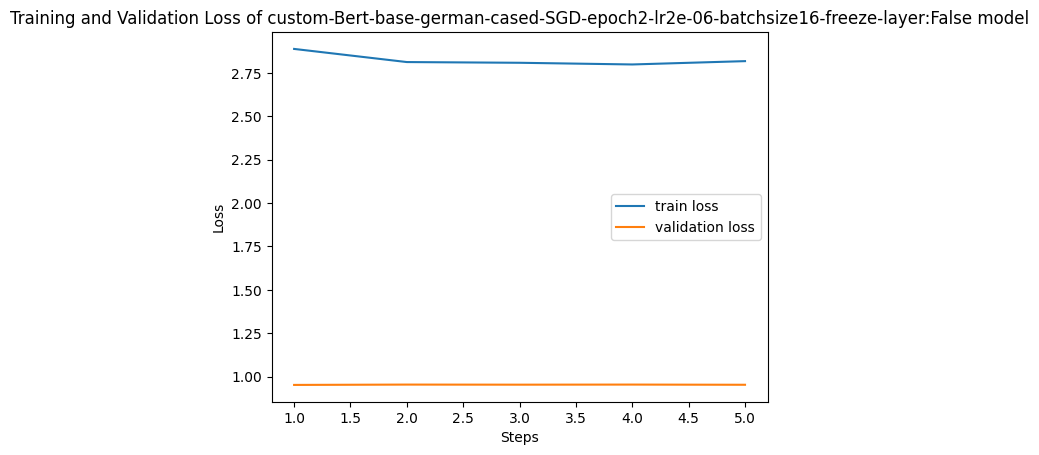

    Label  Correct_preds  Total_preds
0       0              7           28
1       1             28           28
2       2             18           22
3       3             10           24
4       4             25           26
5       5             19           24
6       6              2           24
7       7              0           24
8       8             22           27
9       9             14           24
10     10             21           23
11     11              3           20
12     12              0           20
13     13              0           28
14     14              0           24
15     15             10           29
16     16             25           25
17     17             20           21
18     18              3           18
19     19              0           26
20     20              9           26
21     21              0           19



Hyperparameters: 
 ('Adam', 'lr2e-06', 'batchsize16', 'epoch2') 

Start Training of custom-Dbmdz-bert-base-german-uncased-A

Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.10943396226415095 
100/34 val loss: 1.0349749088287354 
100/298 train accuracy: 0.090625 
100/298 train loss: 4.064985125064849 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.30377358490566037 
100/34 val loss: 1.0184357357025147 
100/298 train accuracy: 0.21125 
100/298 train loss: 4.020495636463165 
Epoch:  2


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.39433962264150946 
100/34 val loss: 1.0032406902313233 
100/298 train accuracy: 0.34502191609267374 
100/298 train loss: 3.9783200240135193 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.41320754716981134 
100/34 val loss: 0.9922192072868348 
100/298 train accuracy: 0.43125 
100/298 train loss: 3.92824826002121 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.4226415094339623 
100/34 val loss: 0.9854205942153931 
100/298 train accuracy: 0.416875 
100/298 train loss: 3.9142199516296388 
0.4226415094339623


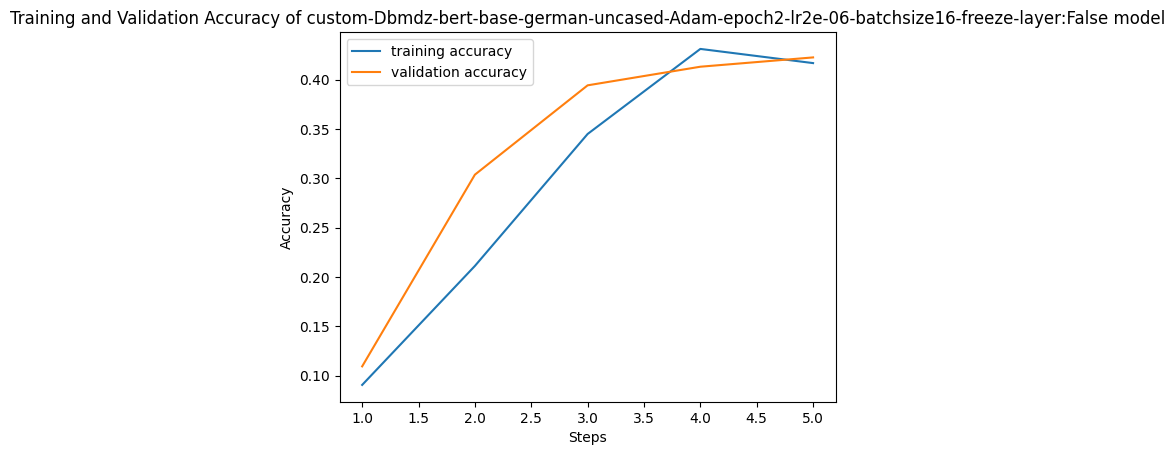

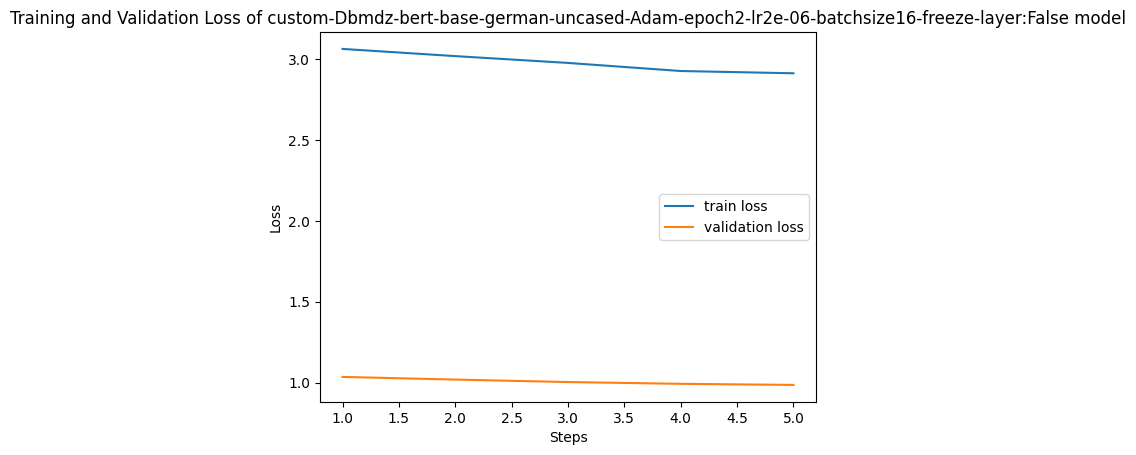

    Label  Correct_preds  Total_preds
0       0             11           28
1       1             28           28
2       2             17           22
3       3              8           24
4       4             24           26
5       5             22           24
6       6              0           24
7       7              0           24
8       8             23           27
9       9              0           24
10     10             22           23
11     11              0           20
12     12              0           20
13     13              0           28
14     14              0           24
15     15              0           29
16     16             25           25
17     17             20           21
18     18              9           18
19     19              3           26
20     20             12           26
21     21              0           19



Hyperparameters: 
 ('SGD', 'lr2e-06', 'batchsize16', 'epoch2') 

Start Training of custom-Dbmdz-bert-base-german-uncased-SG

Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.4320754716981132 
100/34 val loss: 0.9821935749053955 
100/298 train accuracy: 0.35 
100/298 train loss: 3.948582158088684 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.4320754716981132 
100/34 val loss: 0.9828488492965698 
100/298 train accuracy: 0.446875 
100/298 train loss: 3.887341332435608 
Epoch:  2


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.4320754716981132 
100/34 val loss: 0.9816886925697327 
100/298 train accuracy: 0.42705072010018785 
100/298 train loss: 3.8929279088974 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.4320754716981132 
100/34 val loss: 0.9828869438171387 
100/298 train accuracy: 0.455 
100/298 train loss: 3.882030813694 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.4320754716981132 
100/34 val loss: 0.9829948163032531 
100/298 train accuracy: 0.4325 
100/298 train loss: 3.8969618701934814 
0.4320754716981132


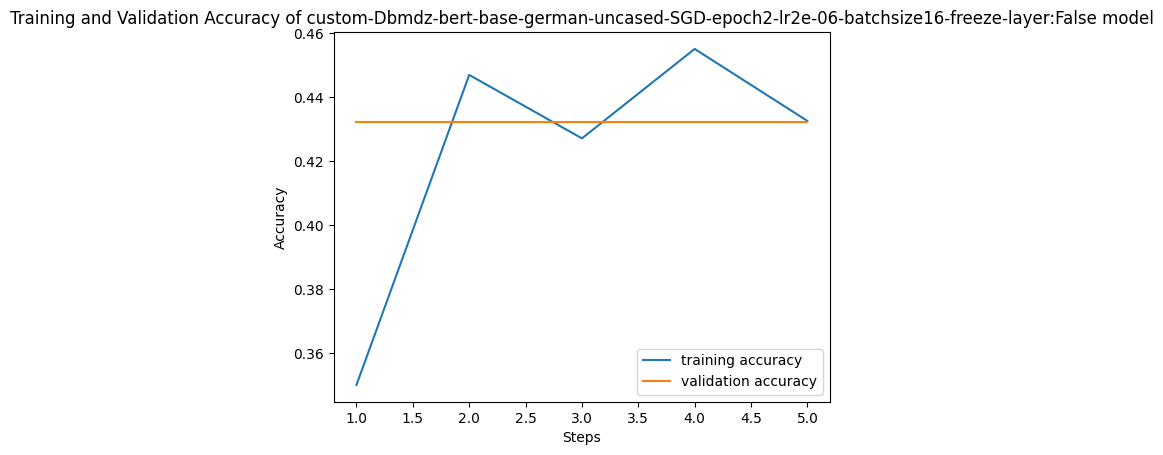

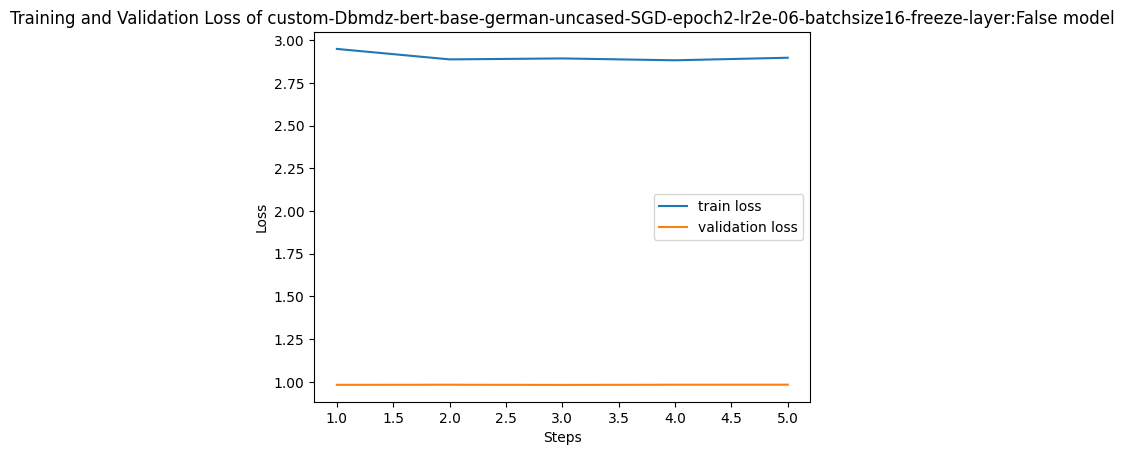

    Label  Correct_preds  Total_preds
0       0             12           28
1       1             28           28
2       2             18           22
3       3              8           24
4       4             24           26
5       5             22           24
6       6              0           24
7       7              0           24
8       8             23           27
9       9              0           24
10     10             22           23
11     11              0           20
12     12              0           20
13     13              0           28
14     14              0           24
15     15              1           29
16     16             25           25
17     17             20           21
18     18             11           18
19     19              3           26
20     20             12           26
21     21              0           19



Hyperparameters: 
 ('Adam', 'lr2e-06', 'batchsize16', 'epoch2') 

Start Training of custom-Deepset-gbert-base-Adam-epoch2-l

Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.18490566037735848 
100/34 val loss: 1.026341953277588 
100/298 train accuracy: 0.116875 
100/298 train loss: 4.0504229497909545 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.4849056603773585 
100/34 val loss: 1.000481331348419 
100/298 train accuracy: 0.33875 
100/298 train loss: 3.9850012636184693 
Epoch:  2


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.590566037735849 
100/34 val loss: 0.9771593523025512 
100/298 train accuracy: 0.5115842204132749 
100/298 train loss: 3.914557845592499 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.6264150943396226 
100/34 val loss: 0.958440146446228 
100/298 train accuracy: 0.610625 
100/298 train loss: 3.841194348335266 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.6339622641509434 
100/34 val loss: 0.9476397585868835 
100/298 train accuracy: 0.614375 
100/298 train loss: 3.8115814661979677 
0.6339622641509434


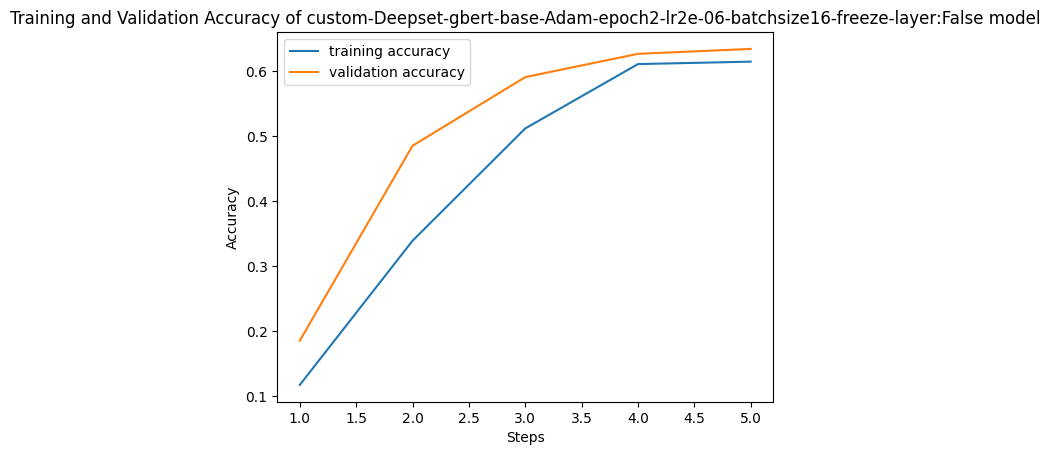

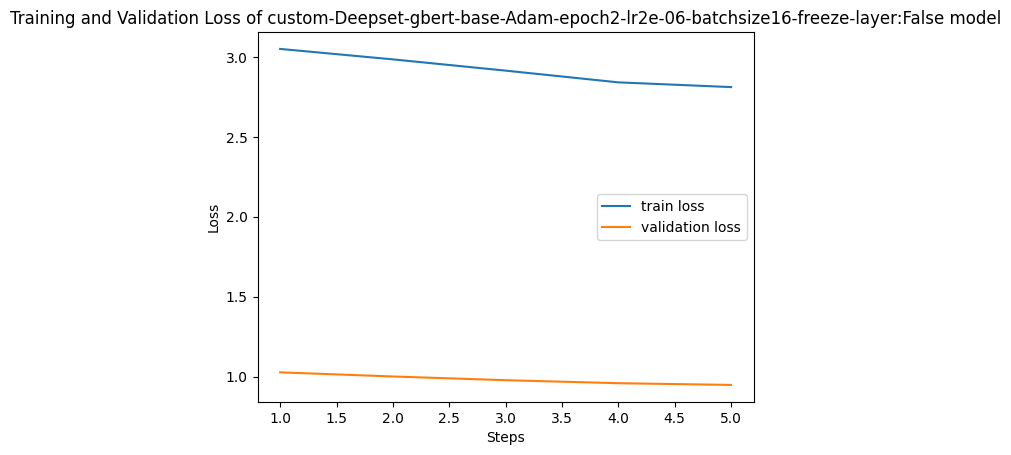

    Label  Correct_preds  Total_preds
0       0             28           28
1       1             28           28
2       2             20           22
3       3             22           24
4       4             25           26
5       5             22           24
6       6              0           24
7       7              0           24
8       8             25           27
9       9              0           24
10     10             22           23
11     11             17           20
12     12              0           20
13     13              0           28
14     14              0           24
15     15             22           29
16     16             25           25
17     17             19           21
18     18             16           18
19     19             21           26
20     20             23           26
21     21              1           19



Hyperparameters: 
 ('SGD', 'lr2e-06', 'batchsize16', 'epoch2') 

Start Training of custom-Deepset-gbert-base-SGD-epoch2-lr2

Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.6339622641509434 
100/34 val loss: 0.9430444049835205 
100/298 train accuracy: 0.585625 
100/298 train loss: 3.8522777819633482 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.6339622641509434 
100/34 val loss: 0.9449652791023254 
100/298 train accuracy: 0.646875 
100/298 train loss: 3.778360857963562 
Epoch:  2


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.6339622641509434 
100/34 val loss: 0.9442003297805787 
100/298 train accuracy: 0.641202254226675 
100/298 train loss: 3.782671084403992 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.6339622641509434 
100/34 val loss: 0.9443633127212524 
100/298 train accuracy: 0.65375 
100/298 train loss: 3.7704215002059938 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.6339622641509434 
100/34 val loss: 0.9441317677497864 
100/298 train accuracy: 0.635625 
100/298 train loss: 3.7857719016075135 
0.6339622641509434


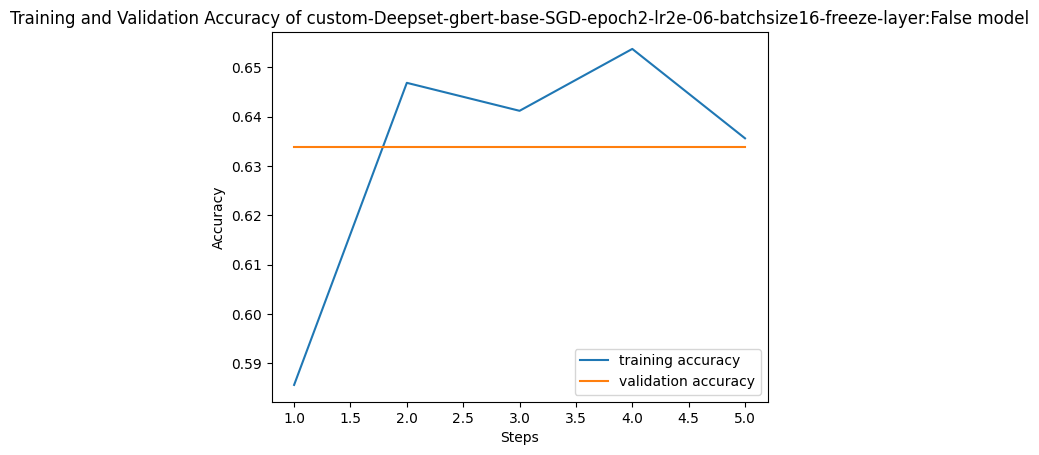

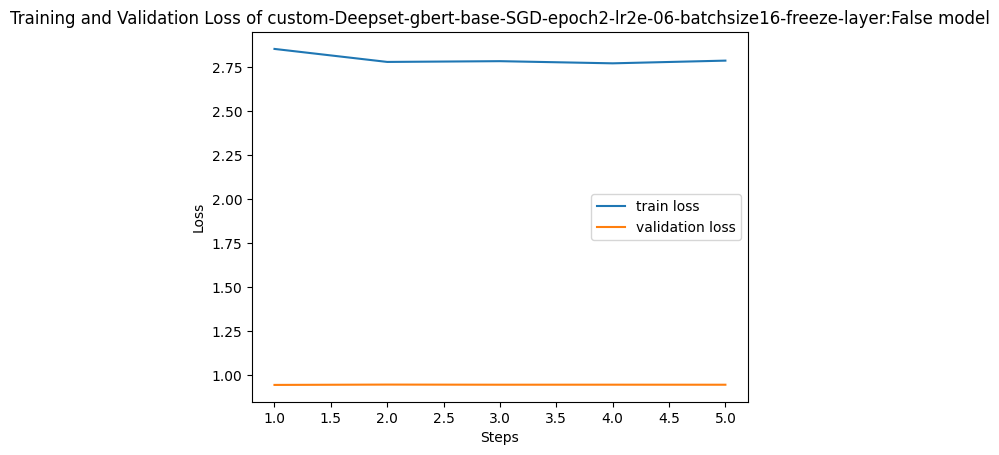

    Label  Correct_preds  Total_preds
0       0             28           28
1       1             28           28
2       2             20           22
3       3             22           24
4       4             25           26
5       5             22           24
6       6              0           24
7       7              0           24
8       8             25           27
9       9              0           24
10     10             22           23
11     11             17           20
12     12              0           20
13     13              0           28
14     14              0           24
15     15             22           29
16     16             25           25
17     17             20           21
18     18             16           18
19     19             21           26
20     20             23           26
21     21              0           19



Hyperparameters: 
 ('Adam', 'lr2e-06', 'batchsize16', 'epoch2') 

Start Training of custom-Xlm-roberta-base-Adam-epoch2-lr2

Some weights of the model checkpoint at Xlm-roberta-base were not used when initializing BertForPreTraining: ['roberta.encoder.layer.4.intermediate.dense.weight', 'roberta.encoder.layer.11.output.dense.bias', 'roberta.encoder.layer.5.attention.self.key.weight', 'roberta.encoder.layer.7.attention.self.key.bias', 'roberta.encoder.layer.10.attention.self.query.weight', 'roberta.encoder.layer.3.attention.output.LayerNorm.weight', 'roberta.encoder.layer.10.attention.self.key.weight', 'roberta.encoder.layer.3.output.LayerNorm.bias', 'roberta.encoder.layer.7.attention.output.LayerNorm.weight', 'roberta.encoder.layer.9.attention.self.query.bias', 'roberta.encoder.layer.11.attention.self.value.weight', 'roberta.encoder.layer.6.output.dense.weight', 'roberta.encoder.layer.7.output.dense.weight', 'roberta.encoder.layer.8.attention.self.key.bias', 'roberta.encoder.layer.9.attention.self.value.weight', 'lm_head.layer_norm.bias', 'roberta.encoder.layer.11.output.LayerNorm.weight', 'roberta.encoder.l

Some weights of BertForPreTraining were not initialized from the model checkpoint at Xlm-roberta-base and are newly initialized: ['encoder.layer.2.output.LayerNorm.bias', 'encoder.layer.1.output.dense.bias', 'encoder.layer.5.output.LayerNorm.bias', 'encoder.layer.9.attention.self.key.bias', 'encoder.layer.10.attention.self.key.bias', 'encoder.layer.10.output.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'cls.predictions.bias', 'encoder.layer.5.attention.output.dense.bias', 'encoder.layer.2.intermediate.dense.bias', 'encoder.layer.7.attention.output.LayerNorm.weight', 'encoder.layer.2.attention.self.key.bias', 'encoder.layer.0.output.dense.bias', 'encoder.layer.10.attention.output.LayerNorm.weight', 'encoder.layer.6.attention.output.LayerNorm.weight', 'encoder.layer.7.attention.self.key.weight', 'encoder.layer.1.attention.self.key.weight', 'encoder.layer.6.output.LayerNorm.weight', 'encoder.layer.1.attention.output.LayerNorm.weight', 'encoder.layer.3.attention.self.key.bias'

Epoch:  1


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.08679245283018867 
100/34 val loss: 1.0476146125793457 
100/298 train accuracy: 0.040625 
100/298 train loss: 4.087507104873657 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.04905660377358491 
100/34 val loss: 1.0447356510162353 
100/298 train accuracy: 0.085 
100/298 train loss: 4.077356343269348 
Epoch:  2


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.1320754716981132 
100/34 val loss: 1.0378369402885437 
100/298 train accuracy: 0.08328115216030056 
100/298 train loss: 4.063180034160614 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.1471698113207547 
100/34 val loss: 1.0302525496482848 
100/298 train accuracy: 0.14375 
100/298 train loss: 4.0406592655181885 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.15283018867924528 
100/34 val loss: 1.021036159992218 
100/298 train accuracy: 0.150625 
100/298 train loss: 4.0203364777565 
0.15283018867924528


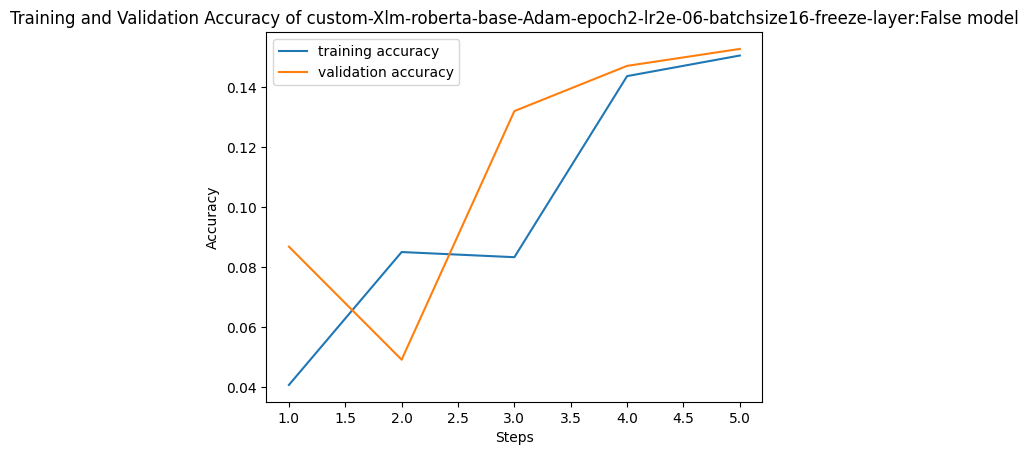

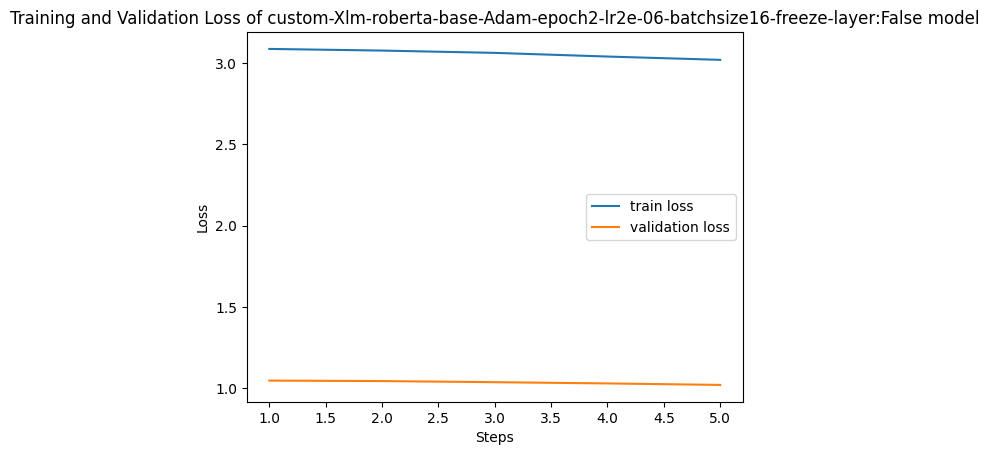

    Label  Correct_preds  Total_preds
0       0              0           28
1       1             28           28
2       2              0           22
3       3              0           24
4       4              0           26
5       5              0           24
6       6              0           24
7       7              1           24
8       8             25           27
9       9              0           24
10     10             18           23
11     11              0           20
12     12              0           20
13     13              0           28
14     14              0           24
15     15              0           29
16     16              9           25
17     17              0           21
18     18              0           18
19     19              0           26
20     20              0           26
21     21              0           19



Hyperparameters: 
 ('SGD', 'lr2e-06', 'batchsize16', 'epoch2') 

Start Training of custom-Xlm-roberta-base-SGD-epoch2-lr2e-

Some weights of the model checkpoint at Xlm-roberta-base were not used when initializing BertForPreTraining: ['roberta.encoder.layer.4.intermediate.dense.weight', 'roberta.encoder.layer.11.output.dense.bias', 'roberta.encoder.layer.5.attention.self.key.weight', 'roberta.encoder.layer.7.attention.self.key.bias', 'roberta.encoder.layer.10.attention.self.query.weight', 'roberta.encoder.layer.3.attention.output.LayerNorm.weight', 'roberta.encoder.layer.10.attention.self.key.weight', 'roberta.encoder.layer.3.output.LayerNorm.bias', 'roberta.encoder.layer.7.attention.output.LayerNorm.weight', 'roberta.encoder.layer.9.attention.self.query.bias', 'roberta.encoder.layer.11.attention.self.value.weight', 'roberta.encoder.layer.6.output.dense.weight', 'roberta.encoder.layer.7.output.dense.weight', 'roberta.encoder.layer.8.attention.self.key.bias', 'roberta.encoder.layer.9.attention.self.value.weight', 'lm_head.layer_norm.bias', 'roberta.encoder.layer.11.output.LayerNorm.weight', 'roberta.encoder.l

Some weights of BertForPreTraining were not initialized from the model checkpoint at Xlm-roberta-base and are newly initialized: ['encoder.layer.2.output.LayerNorm.bias', 'encoder.layer.1.output.dense.bias', 'encoder.layer.5.output.LayerNorm.bias', 'encoder.layer.9.attention.self.key.bias', 'encoder.layer.10.attention.self.key.bias', 'encoder.layer.10.output.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'cls.predictions.bias', 'encoder.layer.5.attention.output.dense.bias', 'encoder.layer.2.intermediate.dense.bias', 'encoder.layer.7.attention.output.LayerNorm.weight', 'encoder.layer.2.attention.self.key.bias', 'encoder.layer.0.output.dense.bias', 'encoder.layer.10.attention.output.LayerNorm.weight', 'encoder.layer.6.attention.output.LayerNorm.weight', 'encoder.layer.7.attention.self.key.weight', 'encoder.layer.1.attention.self.key.weight', 'encoder.layer.6.output.LayerNorm.weight', 'encoder.layer.1.attention.output.LayerNorm.weight', 'encoder.layer.3.attention.self.key.bias'

Epoch:  1


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.17169811320754716 
100/34 val loss: 1.0177863883972167 
100/298 train accuracy: 0.140625 
100/298 train loss: 4.029414145946502 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.17169811320754716 
100/34 val loss: 1.0199397253990172 
100/298 train accuracy: 0.184375 
100/298 train loss: 4.001098926067352 
Epoch:  2


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.17169811320754716 
100/34 val loss: 1.019209053516388 
100/298 train accuracy: 0.1828428303068253 
100/298 train loss: 3.9990045547485353 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.17169811320754716 
100/34 val loss: 1.0203697729110717 
100/298 train accuracy: 0.188125 
100/298 train loss: 3.9976990318298338 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.17169811320754716 
100/34 val loss: 1.0180261874198913 
100/298 train accuracy: 0.1825 
100/298 train loss: 4.001921780109406 
0.17169811320754716


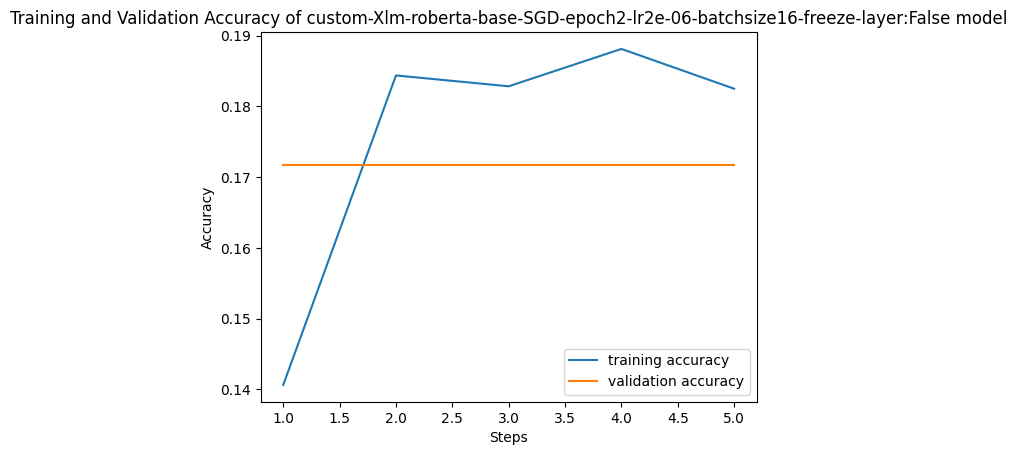

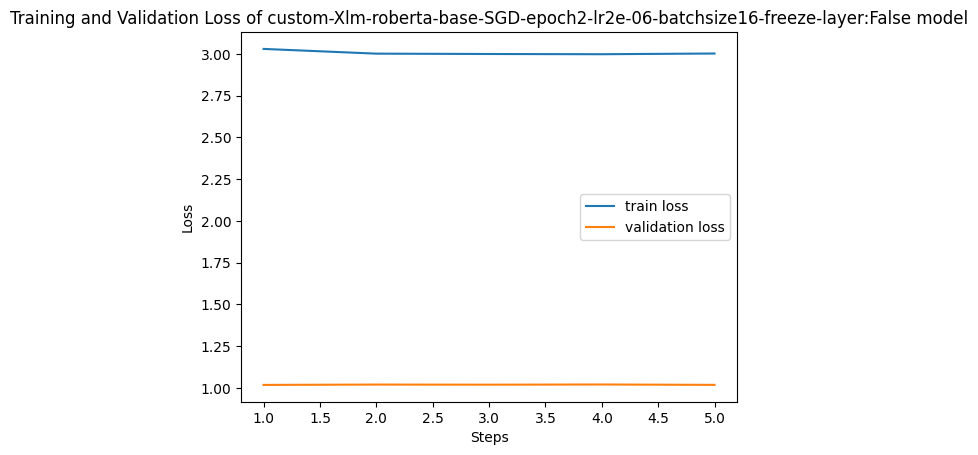

    Label  Correct_preds  Total_preds
0       0              0           28
1       1             28           28
2       2              0           22
3       3              0           24
4       4              0           26
5       5              0           24
6       6              0           24
7       7              1           24
8       8             26           27
9       9              0           24
10     10             18           23
11     11              0           20
12     12              0           20
13     13              0           28
14     14              0           24
15     15              1           29
16     16             17           25
17     17              0           21
18     18              0           18
19     19              0           26
20     20              0           26
21     21              0           19



Hyperparameters: 
 ('Adam', 'lr2e-06', 'batchsize16', 'epoch2') 

Start Training of custom-Uklfr-gottbert-base-Adam-epoch2-

Some weights of the model checkpoint at Uklfr/gottbert-base were not used when initializing BertForPreTraining: ['roberta.encoder.layer.4.intermediate.dense.weight', 'roberta.encoder.layer.11.output.dense.bias', 'roberta.encoder.layer.5.attention.self.key.weight', 'roberta.encoder.layer.7.attention.self.key.bias', 'roberta.encoder.layer.10.attention.self.query.weight', 'roberta.encoder.layer.3.attention.output.LayerNorm.weight', 'roberta.encoder.layer.10.attention.self.key.weight', 'roberta.encoder.layer.3.output.LayerNorm.bias', 'roberta.encoder.layer.7.attention.output.LayerNorm.weight', 'roberta.encoder.layer.9.attention.self.query.bias', 'roberta.encoder.layer.11.attention.self.value.weight', 'roberta.encoder.layer.6.output.dense.weight', 'roberta.encoder.layer.7.output.dense.weight', 'roberta.encoder.layer.8.attention.self.key.bias', 'roberta.encoder.layer.9.attention.self.value.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'roberta.encoder.layer.11.output.LayerNorm.

Some weights of BertForPreTraining were not initialized from the model checkpoint at Uklfr/gottbert-base and are newly initialized: ['encoder.layer.2.output.LayerNorm.bias', 'encoder.layer.1.output.dense.bias', 'encoder.layer.5.output.LayerNorm.bias', 'encoder.layer.9.attention.self.key.bias', 'encoder.layer.10.attention.self.key.bias', 'encoder.layer.10.output.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'cls.predictions.bias', 'encoder.layer.5.attention.output.dense.bias', 'encoder.layer.2.intermediate.dense.bias', 'encoder.layer.7.attention.output.LayerNorm.weight', 'encoder.layer.2.attention.self.key.bias', 'encoder.layer.0.output.dense.bias', 'encoder.layer.10.attention.output.LayerNorm.weight', 'encoder.layer.6.attention.output.LayerNorm.weight', 'encoder.layer.7.attention.self.key.weight', 'encoder.layer.1.attention.self.key.weight', 'encoder.layer.6.output.LayerNorm.weight', 'encoder.layer.1.attention.output.LayerNorm.weight', 'encoder.layer.3.attention.self.key.bi

Epoch:  1


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.07547169811320754 
100/34 val loss: 1.0484671759605408 
100/298 train accuracy: 0.050625 
100/298 train loss: 4.088178570270538 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.05471698113207547 
100/34 val loss: 1.0431006121635438 
100/298 train accuracy: 0.07125 
100/298 train loss: 4.075641207695007 
Epoch:  2


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.1509433962264151 
100/34 val loss: 1.036380808353424 
100/298 train accuracy: 0.09142141515341265 
100/298 train loss: 4.055592699050903 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.1660377358490566 
100/34 val loss: 1.0288576459884644 
100/298 train accuracy: 0.13375 
100/298 train loss: 4.032091317176819 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.2169811320754717 
100/34 val loss: 1.0220162081718445 
100/298 train accuracy: 0.1925 
100/298 train loss: 4.016012477874756 
0.2169811320754717


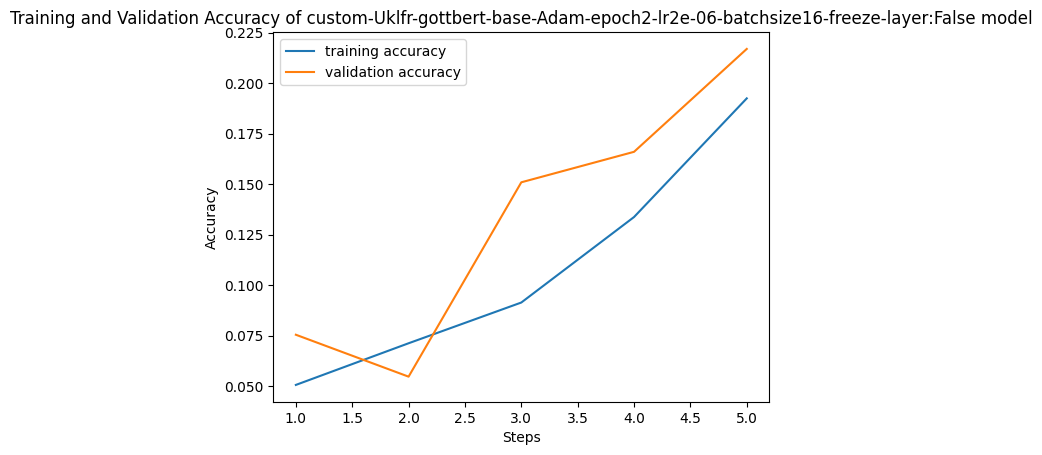

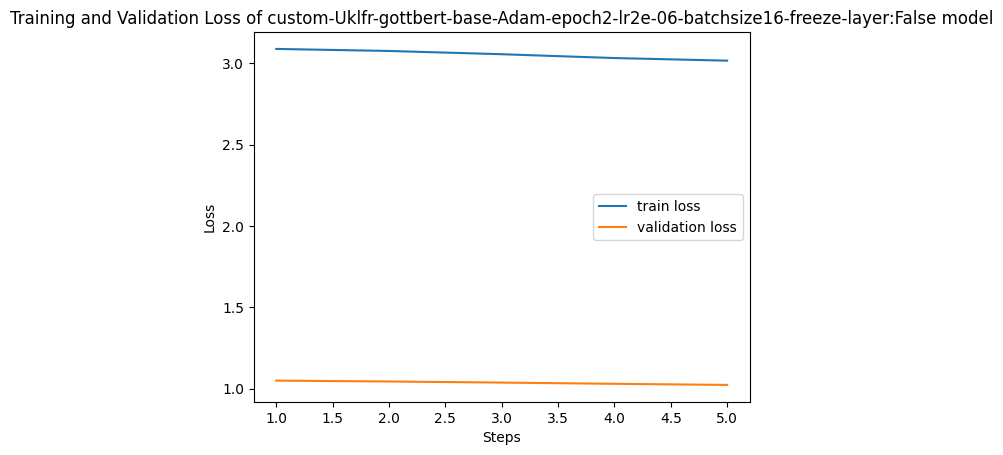

    Label  Correct_preds  Total_preds
0       0              0           28
1       1             28           28
2       2             17           22
3       3              0           24
4       4              0           26
5       5              0           24
6       6              0           24
7       7              0           24
8       8              0           27
9       9              0           24
10     10             21           23
11     11              0           20
12     12              0           20
13     13              4           28
14     14              0           24
15     15             22           29
16     16             18           25
17     17              0           21
18     18              1           18
19     19              4           26
20     20              0           26
21     21              0           19



Hyperparameters: 
 ('SGD', 'lr2e-06', 'batchsize16', 'epoch2') 

Start Training of custom-Uklfr-gottbert-base-SGD-epoch2-lr

Some weights of the model checkpoint at Uklfr/gottbert-base were not used when initializing BertForPreTraining: ['roberta.encoder.layer.4.intermediate.dense.weight', 'roberta.encoder.layer.11.output.dense.bias', 'roberta.encoder.layer.5.attention.self.key.weight', 'roberta.encoder.layer.7.attention.self.key.bias', 'roberta.encoder.layer.10.attention.self.query.weight', 'roberta.encoder.layer.3.attention.output.LayerNorm.weight', 'roberta.encoder.layer.10.attention.self.key.weight', 'roberta.encoder.layer.3.output.LayerNorm.bias', 'roberta.encoder.layer.7.attention.output.LayerNorm.weight', 'roberta.encoder.layer.9.attention.self.query.bias', 'roberta.encoder.layer.11.attention.self.value.weight', 'roberta.encoder.layer.6.output.dense.weight', 'roberta.encoder.layer.7.output.dense.weight', 'roberta.encoder.layer.8.attention.self.key.bias', 'roberta.encoder.layer.9.attention.self.value.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'roberta.encoder.layer.11.output.LayerNorm.

Some weights of BertForPreTraining were not initialized from the model checkpoint at Uklfr/gottbert-base and are newly initialized: ['encoder.layer.2.output.LayerNorm.bias', 'encoder.layer.1.output.dense.bias', 'encoder.layer.5.output.LayerNorm.bias', 'encoder.layer.9.attention.self.key.bias', 'encoder.layer.10.attention.self.key.bias', 'encoder.layer.10.output.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'cls.predictions.bias', 'encoder.layer.5.attention.output.dense.bias', 'encoder.layer.2.intermediate.dense.bias', 'encoder.layer.7.attention.output.LayerNorm.weight', 'encoder.layer.2.attention.self.key.bias', 'encoder.layer.0.output.dense.bias', 'encoder.layer.10.attention.output.LayerNorm.weight', 'encoder.layer.6.attention.output.LayerNorm.weight', 'encoder.layer.7.attention.self.key.weight', 'encoder.layer.1.attention.self.key.weight', 'encoder.layer.6.output.LayerNorm.weight', 'encoder.layer.1.attention.output.LayerNorm.weight', 'encoder.layer.3.attention.self.key.bi

Epoch:  1


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.2528301886792453 
100/34 val loss: 1.01976877450943 
100/298 train accuracy: 0.165 
100/298 train loss: 4.031602606773376 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.2528301886792453 
100/34 val loss: 1.0206615209579468 
100/298 train accuracy: 0.23875 
100/298 train loss: 4.000612893104553 
Epoch:  2


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.2528301886792453 
100/34 val loss: 1.0202930212020873 
100/298 train accuracy: 0.2654978083907326 
100/298 train loss: 3.996162052154541 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.2528301886792453 
100/34 val loss: 1.0210697722434998 
100/298 train accuracy: 0.26 
100/298 train loss: 3.995587203502655 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.2528301886792453 
100/34 val loss: 1.0193829655647277 
100/298 train accuracy: 0.241875 
100/298 train loss: 4.001444749832153 
0.2528301886792453


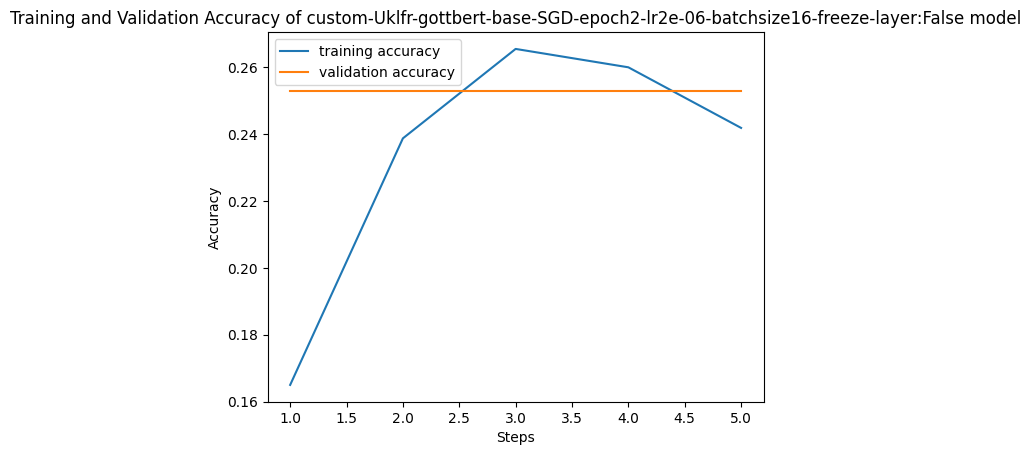

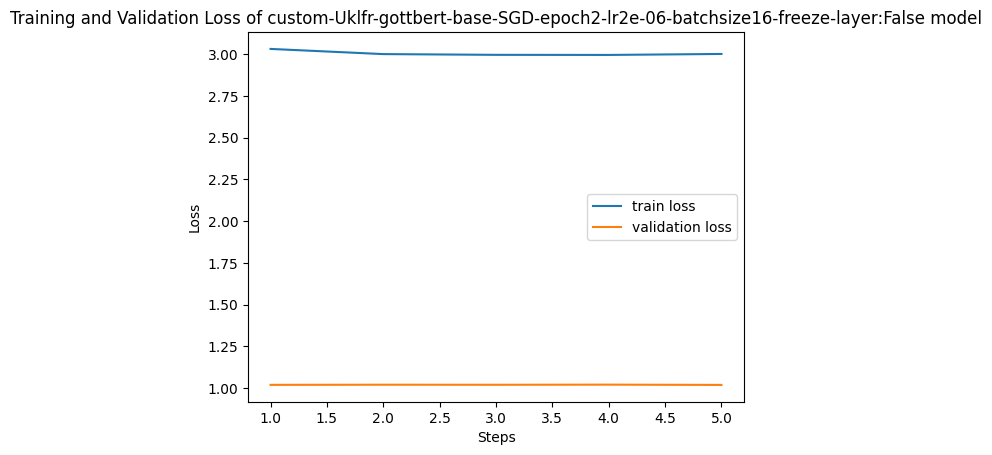

    Label  Correct_preds  Total_preds
0       0              0           28
1       1             28           28
2       2             17           22
3       3              0           24
4       4             16           26
5       5              0           24
6       6              0           24
7       7              0           24
8       8              0           27
9       9              0           24
10     10             18           23
11     11              0           20
12     12              0           20
13     13              4           28
14     14              0           24
15     15             20           29
16     16             25           25
17     17              0           21
18     18              1           18
19     19              5           26
20     20              0           26
21     21              0           19



╒══════════════════════════════════════════════════════════════════════════════════════════╤══════════╤═══════════╤════════

In [19]:
""" this code will run the models with custom head.
this can be alter by changing the custom head from True to False
the weights of the base model is currently not freeeze that 
can be freezed by changing the freeze layers from false to True """

trained_models_file = 'trained_models.txt'
best_params_dict_path = 'best_params.json'

df = pickle.load(open('dataset/230130_SmallOberkategorie.pickle', 'rb'))
label_names = df['labels'].unique()
# label_names

X = df[['text']]
y = df['labels']
X_train, X_val, y_train, y_val = split_df(X, y)

custom_head = False
freeze_layers = False
optimizers = [Adam, SGD]
learning_rates = [2e-4, 2e-5, 2e-6]
epochs = [20, 30]
batch_sizes = [16, 32]

configs =     {'custom_head': custom_head, 'freeze_layers': freeze_layers,
               'optimizers': optimizers, 'epochs': epochs, 'batch_sizes': batch_sizes,
               'learning_rates': learning_rates, 'val_steps':100}
dataset = {'X_train': X_train, 'y_train': y_train, 'X_val': X_val, 'y_val': y_val}

models = [
    'Bert-base-german-cased', 
'Dbmdz/bert-base-german-uncased',
'Deepset/gbert-base',
'Xlm-roberta-base',
'Uklfr/gottbert-base'
]

# training without custom head
training(models, configs, dataset)

# training with custom head
configs['custom_head'] = True
training(models, configs, dataset)

# Testing

In [21]:
def validator(model, test_dataloader):
    model.eval()
    test_label = []
    test_pred = []
    test_loss= 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        for step_num, batch_data in tqdm(enumerate(test_dataloader)):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            loss = output.loss
            test_loss += loss.item()
            
            test_label.append(labels.cpu().detach().numpy())
            test_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
    
    test_label = np.concatenate(test_label)
    test_pred = np.concatenate(test_pred)
    
    return test_label, test_pred

In [25]:
def testing(models, best_params, configs, dataset):
    
    custom_head = configs['custom_head']
    freeze_layers = True
    X_test, y_test = dataset.values() 
    
    custom_head_label = 'custom' if custom_head else 'base'
    model_function = CustomModel2 if custom_head else CustomModel1

    #dic form store results of all models
    collect_test_results_of_all_model= {
        'Metrics':['accuracy','precision','recall','f1-score', 'MCC']
    }
    
    for model_name in models:
        model_str = str(model_name).replace('/', '-')
        model_identifier = custom_head_label + '-' + model_str
        model_params = best_params[model_identifier]
        optimizer = model_params['optimizer']
        batch_size = model_params['batch_size']
        learning_rate = model_params['learning_rate']
        num_epochs = model_params['epochs']

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        test_dataloader = preprocess_dataset(model_name, X_test, y_test, batch_size)
        
        
        optimizer_str = str(optimizer).split('.')[-1].split("'")[0]
        epoch_str = 'epoch' + str(num_epochs)
        lr_str = 'lr' + str(learning_rate)
        batch_size_str = 'batchsize' + str(batch_size)
        model_variant = f'{custom_head_label}-{model_str}-{optimizer_str}-{epoch_str}-{lr_str}-{batch_size_str}'
        model_url = 'models/' + model_identifier + '.pth'

        if os.path.exists(model_url): 
            
            print("===========================================")
            print(f"Hyperparameters: \n {optimizer_str, lr_str, batch_size_str, epoch_str} \n")
            print("Start Testing of {}".format(model_variant))
            print("===========================================")
        
        
            model = model_function(checkpoint=model_name, num_labels=len(label_names)).to(device)
            model.load_state_dict(torch.load(model_url))
            test_label, test_pred = validator(model, test_dataloader)

            calculate_classification_reprot(label_names, test_label, test_pred, model_variant)
            plot_confusion_matrix(test_pred, test_label, label_names, False, model_variant)
            
            collect_test_results_of_all_model[model_variant] = get_evaluation_results(test_label, test_pred)
    
    metrics_data_frame = pd.DataFrame.from_dict(collect_test_results_of_all_model, orient='index')
    return metrics_data_frame

<span style='color:red'>P3<span>

In [26]:
# df = pickle.load(open('path of the test set.pickle', 'rb'))

X = X_val # change with df['text'] for test text
y = y_val # change with df['label'] for test labels

with open("best_params.json", "r") as fp:
    best_prams = json.load(fp)

custom_head = True
# freeze_layers = False
dataset = {'X_test': X, 'y_test': y}
configs =     {'custom_head': custom_head}

models = [
    'Bert-base-german-cased'
]

metrics_data_frame = testing(models, best_prams, configs, dataset)
print("\n\n")
metrics_data_frame

Hyperparameters: 
 ('Adam', 'lr2e-06', 'batchsize16', 'epoch2') 

Start Testing of custom-Bert-base-german-cased-Adam-epoch2-lr2e-06-batchsize16


0it [00:00, ?it/s]

classifiation report of custom-Bert-base-german-cased-Adam-epoch2-lr2e-06-batchsize16 model
              precision    recall  f1-score   support

           0       0.25      1.00      0.40         7
           1       1.00      0.33      0.49        86
           2       0.82      0.67      0.73        27
           3       0.42      0.71      0.53        14
           4       0.96      1.00      0.98        25
           5       0.79      0.95      0.86        20
           6       0.08      0.40      0.14         5
           7       0.00      0.00      0.00         0
           8       0.81      0.92      0.86        24
           9       0.58      0.11      0.19       127
          10       0.91      0.84      0.87        25
          11       0.15      0.16      0.15        19
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.34      0.20      0.25

,0,1,2,3,4
Metrics,accuracy,precision,recall,f1-score,MCC
custom-Bert-base-german-cased-Adam-epoch2-lr2e-06-batchsize16,0.4453,0.4486,0.436,0.4002,0.434


## check mismatches

In [28]:
label_df = pd.read_csv('label_dict.csv')
keys = label_df['Id']
label = label_df['Product']
label_dict = dict(zip(keys, label))

In [30]:
def unit_testing(model_name, best_params, configs, test_dataloader):
    custom_head = configs['custom_head']
#     freeze_layers = configs['freeze_layers']
    
    custom_head_label = 'custom' if custom_head else 'base'
    model_function = CustomModel2 if custom_head else CustomModel1
    X, y = dataset.values() 
    
    model_str = str(model_name).replace('/', '-')
    model_identifier = custom_head_label + '-' + model_str
    model_params = best_params[model_identifier]
    optimizer = model_params['optimizer']
    batch_size = model_params['batch_size']
    learning_rate = model_params['learning_rate']
    num_epochs = model_params['epochs']
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_dataloader = preprocess_dataset(model_name, X, y, batch_size)
    
    optimizer_str = str(optimizer).split('.')[-1].split("'")[0]
    epoch_str = 'epoch' + str(num_epochs)
    lr_str = 'lr' + str(learning_rate)
    batch_size_str = 'batchsize' + str(batch_size)
    model_variant = f'{custom_head_label}-{model_str}-{optimizer_str}-{epoch_str}-{lr_str}-{batch_size_str}'
    model_url = 'models/' + model_identifier + '.pth'
    
    
    if os.path.exists(model_url):

        model = model_function(checkpoint=model_name, num_labels=len(label_names)).to(device)
        model.load_state_dict(torch.load(model_url))
        test_label, test_pred = validator(model, test_dataloader)

        return test_label, test_pred
    
    return "trained model doesn't exist on path!"


with open("best_params.json", "r") as fp:
    best_prams = json.load(fp)

custom_head = True
freeze_layers = False
configs = {'custom_head': custom_head, 'freeze_layers': freeze_layers}
dataset = {'X_test': X, 'y_test': y}
model_name = 'Bert-base-german-cased'

test_label, test_pred = unit_testing(model_name, best_prams, configs, dataset)

pred_df = X
pred_df['test_key'] = test_label
pred_df['test_label'] = pred_df['test_key'].replace(label_dict)
pred_df['pred_key'] = test_pred
pred_df['pred_label'] = pred_df['pred_key'].replace(label_dict)

mismatch_df = pred_df[pred_df['test_key'] != pred_df['pred_key']]
mismatch_df.to_csv(f'predictions/{model_name}-incorrect-predictions.csv')
print(mismatch_df.shape)
mismatch_df.head(10)

0it [00:00, ?it/s]

(294, 5)


,text,test_key,test_label,pred_key,pred_label
20352,stall_46298_120x180_de<br />Abmessung: 120 cm ...,0,Akkus,1,Arbeitsspeicher
72240,<p><b>Warnhinweis:</b></p><p><b>Achtung</b>!? ...,14,Ohrringe,1,Arbeitsspeicher
108298,<b>Eigenschaften für D2UL18549/1:</b> Lotus Bl...,7,Hosen,15,Pullover
100115,<p><span><strong>Italienische Echtleder Busine...,15,Pullover,3,Bilder
85233,"<p><b>BROTECT Matte Displayschutzfolie, der st...",13,Lampen,9,Jacken
39989,Umstandshose 40-21040 Bellybutton schwarz Mark...,5,Gardinen,10,Kalender
72119,Auf 13 wundervollen Fotos zeigt die Tierfotogr...,12,Kleider,9,Jacken
41994,<p>Passgenaue Silikon Hülle aus hochwertigem T...,10,Kalender,9,Jacken
42931,Sportedition. Sportive Sweatshirtjacke in eine...,19,Schürzen,9,Jacken
72283,Der in Ostfriesland geborene Pomologe Johannes...,18,Schutzfolien,1,Arbeitsspeicher


## Attention Wights

In [33]:
with open("best_params.json", "r") as fp:
    best_params = json.load(fp)
    
custom_head = True
freeze_layers = False
configs = {'custom_head': custom_head}

custom_head_label = 'custom' if custom_head else 'base'
model_function = CustomModel2 if custom_head else CustomModel1

# Load pre-trained model and tokenizer
model_name = 'Bert-base-german-cased'
model_str = str(model_name).replace('/', '-')
model_identifier = custom_head_label + '-' + model_str
model_params = best_params[model_identifier]
optimizer = model_params['optimizer']
batch_size = model_params['batch_size']
learning_rate = model_params['learning_rate']
num_epochs = model_params['epochs']

optimizer_str = str(optimizer).split('.')[-1].split("'")[0]
epoch_str = 'epoch' + str(num_epochs)
lr_str = 'lr' + str(learning_rate)
batch_size_str = 'batchsize' + str(batch_size)
model_variant = f'{custom_head_label}-{model_str}-{optimizer_str}-{epoch_str}-{lr_str}-{batch_size_str}'
model_url = 'models/' + model_identifier + '.pth'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = model_function(checkpoint=model_name, num_labels=len(label_names)).to(device)
model.load_state_dict(torch.load(model_url))

# Encode input sentence and get attention masks
input_sentence = "This is a sample input sentence to visualize attention weights."
input_tokens = tokenizer.encode(input_sentence, add_special_tokens=True)
input_tensor = torch.tensor([input_tokens]).to(device)
attention_mask = torch.ones_like(input_tensor).to(device)

# Forward pass through the model to get attention weights
outputs = model(input_tensor, attention_mask=attention_mask)
attentions = outputs[-1]

# Iterate over each layer and head to visualize attention weights
for layer, layer_attentions in enumerate(attentions):
    print(f"Layer {layer+1}:")
    for head, head_attentions in enumerate(layer_attentions):
        print(f"Head {head+1}:")
        for token, weight in zip(input_tokens, head_attentions):
            print(f"{tokenizer.decode([token])} - {weight[0][0].item():.4f}")
        print("\n")

Layer 1:
Head 1:
[CLS] - 0.0302
Th - 0.3363
##is - 0.0463
is - 0.0377
a - 0.0082
sa - 0.4622
##m - 0.0627
##ple - 0.0218
in - 0.0136
##put - 0.5267
sen - 0.0093
##ten - 0.0001


Layer 2:
Head 1:
[CLS] - 0.7273
Th - 0.8083
##is - 0.9989
is - 0.7756
a - 0.9881
sa - 0.7912
##m - 0.6934
##ple - 0.8097
in - 0.8664
##put - 0.3542
sen - 0.0932
##ten - 0.1030


Layer 3:
Head 1:
[CLS] - 0.8528
Th - 0.2691
##is - 0.3116
is - 0.7887
a - 0.8274
sa - 0.1145
##m - 0.5952
##ple - 0.7037
in - 0.3777
##put - 0.2369
sen - 0.7129
##ten - 0.7741


Layer 4:
Head 1:
[CLS] - 0.6241
Th - 0.0763
##is - 0.1515
is - 0.5865
a - 0.1685
sa - 0.3277
##m - 0.6287
##ple - 0.5653
in - 0.0621
##put - 0.4831
sen - 0.4929
##ten - 0.1611


Layer 5:
Head 1:
[CLS] - 0.0268
Th - 0.2936
##is - 0.0676
is - 0.0103
a - 0.1301
sa - 0.3292
##m - 0.0964
##ple - 0.2503
in - 0.1272
##put - 0.0726
sen - 0.7087
##ten - 0.2150


Layer 6:
Head 1:
[CLS] - 0.2436
Th - 0.1362
##is - 0.1088
is - 0.0469
a - 0.1647
sa - 0.2780
##m - 0.0023
##pl